# Machinery

In [1]:
Mac_ = True

import pandas as pd
import numpy as np

reload_data = True
recalc_everything = True
save_figures = True

import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.enable('default')
import altair_saver
import selenium

save_figures = True
import vl_convert as vlc
def save_chart(chart_to_save, filename):
    svg_str = vlc.vegalite_to_svg(chart_to_save.to_json())
    with open(filename, "wt") as f:
        f.write(svg_str)

from termcolor import colored
import io
import os

from IPython.display import Markdown as md

%matplotlib inline
%config matplotlib_inline.matplotlib_formats = 'retina'
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

import pathlib
import platform

import cmdstanpy as cmdstan
import arviz as az
import warnings
standistribdir = '../../../../CmdStan'
cmdstan.set_cmdstan_path(standistribdir[3:] if Mac_ else standistribdir)

mainstandirname = '../../../Taiwan_Backup/Taiwan-Omicron_incper_2023'
os.makedirs(mainstandirname, exist_ok=True)
os.makedirs("results", exist_ok=True)

num_iterations = 12500
num_warmup = 2500
num_chains = 4

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5),
             "q25": lambda x: np.percentile(x, 25),
             "median": lambda x: np.percentile(x, 50),
             "q75": lambda x: np.percentile(x, 75),
             "q95": lambda x: np.percentile(x, 95),
             "q97.5": lambda x: np.percentile(x, 97.5)}

def get_stats(cmdstan_data, varnames, round_to_=5):
    # include mean and hdi
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25','median','q75', 'q95', 'q97.5','ess_bulk','ess_tail','r_hat']]

def get_stats_2d(cmdstan_data, varnames, rounding=2):
    # include mean and hpd
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95, round_to=rounding).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50, round_to=rounding).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False, round_to=rounding).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else x for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25',
                        'median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

clrs_ = ["#00a1d5", "#fee391", "#d8daeb", "#bababa", "k"] # via https://nanx.me/ggsci/index.html #blue = #74add1 #yellow = #fee391

# min reference date
mindate = pd.to_datetime('2021-12-20', format='%Y-%m-%d')
truncation_date = pd.to_datetime('2022-02-25', format='%Y-%m-%d')

datemin_plt = pd.to_datetime('2021-12-25', format='%Y-%m-%d')
datemax_plt = truncation_date
##########################

outputfile_parquet_inc = 'data_inc.parquet.gzip'

parquet_args = {
    'coerce_timestamps': 'us',
    'allow_truncated_timestamps': True,
}

import rpy2.rinterface
%load_ext rpy2.ipython
rpy2.robjects.r['options'](warn=-1)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='arviz')
from pytz_deprecation_shim import PytzUsageWarning
warnings.filterwarnings('ignore', category=PytzUsageWarning)

import pyreadr

# <font color="purple">Loading the data</font>

In [2]:
df_inc = pd.read_excel('../data/linelist.xlsx')
for col_dates in df_inc.columns:
    if '日' in col_dates:
        print(colored(col_dates, 'blue'))
        df_inc[col_dates] = pd.to_datetime(df_inc[col_dates], format="%Y-%m-%d")
df_inc

首次曝光日
末次曝光日
發病日


案號 性別     年齡      首次曝光日      末次曝光日        發病日 vaccination
0    1  男  18-49 2021-12-22 2021-12-27 2021-12-27         NaN
1    2  女  18-49 2021-12-22 2021-12-28 2021-12-28         NaN
2    3  女  18-49 2021-12-22 2021-12-24 2021-12-28         NaN
3    4  女    50+ 2021-12-25 2021-12-29 2021-12-30           是
4    5  女    50+ 2021-12-25 2021-12-31 2022-01-01           是
..  .. ..    ...        ...        ...        ...         ...
64  65  女  18-49 2022-01-04 2022-01-07 2022-01-08           是
65  66  女  18-49        NaT 2022-01-07 2022-01-09           是
66  67  男  18-49 2022-01-07 2022-01-07 2022-01-10           是
67  68  女  18-49 2022-01-07 2022-01-07 2022-01-10         NaN
68  69  女    50+ 2022-01-07 2022-01-11 2022-01-17           是

[69 rows x 7 columns]

In [3]:
# creating new columns in number of days not dates
for col_dates in df_inc.columns:
    if '日' in col_dates:
        df_inc[col_dates+"期"] = (df_inc[col_dates] - df_inc['末次曝光日']).dt.days
df_inc

案號 性別     年齡      首次曝光日      末次曝光日        發病日 vaccination  首次曝光日期  末次曝光日期  \
0    1  男  18-49 2021-12-22 2021-12-27 2021-12-27         NaN    -5.0       0   
1    2  女  18-49 2021-12-22 2021-12-28 2021-12-28         NaN    -6.0       0   
2    3  女  18-49 2021-12-22 2021-12-24 2021-12-28         NaN    -2.0       0   
3    4  女    50+ 2021-12-25 2021-12-29 2021-12-30           是    -4.0       0   
4    5  女    50+ 2021-12-25 2021-12-31 2022-01-01           是    -6.0       0   
..  .. ..    ...        ...        ...        ...         ...     ...     ...   
64  65  女  18-49 2022-01-04 2022-01-07 2022-01-08           是    -3.0       0   
65  66  女  18-49        NaT 2022-01-07 2022-01-09           是     NaN       0   
66  67  男  18-49 2022-01-07 2022-01-07 2022-01-10           是     0.0       0   
67  68  女  18-49 2022-01-07 2022-01-07 2022-01-10         NaN     0.0       0   
68  69  女    50+ 2022-01-07 2022-01-11 2022-01-17           是    -4.0       0   

    發病日期  
0      0  
1      0  
2      4  
3      1  
4      1  
..   ...  
64     1  
65     2  
66     3  
67     3  
68     6  

[69 rows x 10 columns]

In [4]:
右截斷日_inc = pd.to_datetime("2022-01-18", format='%Y-%m-%d')
print(colored('Cutoff date: '+右截斷日_inc.strftime("%Y-%m-%d"), 'red'))

Cutoff date: 2022-01-18


In [5]:
df_inc['右截斷日期'] = (右截斷日_inc - df_inc['末次曝光日']).dt.days

**Characteristics of the collected dataset**

In [6]:
#It's not a part of the shared dataset, but the total number of cases confirmed during the studied period was 1151
total_all_cases = 1151
print(colored("Total: "+str(total_all_cases)+" cases",'blue'))

Total: 1151 cases


In [7]:
# total number of local cases
total_local = 114
print(colored("Total local: "+str(total_local)+" cases",'blue'))
# total number of imported cases
total_imported = total_all_cases - total_local
print(colored("Total imported: "+str(total_imported)+" cases",'blue'))

Total local: 114 cases
Total imported: 1037 cases


In [8]:
print(colored("Among local cases not recorded in our dataset: "+str(total_local - df_inc.shape[0])+" cases",'blue'))

Among local cases not recorded in our dataset: 45 cases


In [9]:
df_inc['vaccination'] = [1 if vaccination=='是' else (0 if vaccination=='否' else -1) for vaccination in df_inc.vaccination]

In [10]:
# completely observed
df_inc_observed = df_inc.loc[lambda d: (~pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))]
N_inc_observed = len(df_inc_observed)
# right censored
df_inc_censored = df_inc.loc[lambda d: (pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))]
N_inc_censored = len(df_inc_censored)

# total number of analyzed cases 
N_inc = N_inc_observed + N_inc_censored
df_inc = pd.concat([df_inc_observed, df_inc_censored], ignore_index=True)

md(f"In this part we analyzed the first {total_local} local infections of Omicron variant which were reported in Taiwan in December 2021 – January 2022. In each case we attempted to determine the exposure and symptom onset time intervals. In the best situation, the interval can be identified with precision to one day. However, some records did not contained either the exposure interval or the symptom onset interval completely. These records were omitted from the analysis. Otherwise, the time interval was identified at least partially, either with known lower or with known upper boundary of the time interval.\n \n Additionally, we performed the following assignments: \n * when the upper boundary of the exposure interval was unidentified, it was set to the upper boundary of the symptom onset interval \n * when the upper boudary of the exposure interval was later that the upper boundary of the symptom onset interval, it was set to the latter \n * all onset dates were definitive in the dataset, so the respective interval was a one-day long \n * the requirement that the symptom onset cannot happen earlier than the exposure to the virus was also incurred. \n \n In total **{len(df_inc)} records** were aggregated, which included:\n * **{N_inc_observed} records** with completely observed exposure interval \n * **{N_inc_censored} records** with right censored exposure interval")

In this part we analyzed the first 114 local infections of Omicron variant which were reported in Taiwan in December 2021 – January 2022. In each case we attempted to determine the exposure and symptom onset time intervals. In the best situation, the interval can be identified with precision to one day. However, some records did not contained either the exposure interval or the symptom onset interval completely. These records were omitted from the analysis. Otherwise, the time interval was identified at least partially, either with known lower or with known upper boundary of the time interval.
 
 Additionally, we performed the following assignments: 
 * when the upper boundary of the exposure interval was unidentified, it was set to the upper boundary of the symptom onset interval 
 * when the upper boudary of the exposure interval was later that the upper boundary of the symptom onset interval, it was set to the latter 
 * all onset dates were definitive in the dataset, so the respective interval was a one-day long 
 * the requirement that the symptom onset cannot happen earlier than the exposure to the virus was also incurred. 
 
 In total **69 records** were aggregated, which included:
 * **65 records** with completely observed exposure interval 
 * **4 records** with right censored exposure interval

In [11]:
# one-day exposure window
df_inc_observed.loc[lambda d: d.首次曝光日期-d.末次曝光日期==-1]

案號 性別     年齡      首次曝光日      末次曝光日        發病日  vaccination  首次曝光日期  \
20  21  男  18-49 2022-01-06 2022-01-07 2022-01-10           -1    -1.0   
27  28  女  18-49 2022-01-06 2022-01-07 2022-01-09            1    -1.0   
29  30  女  18-49 2022-01-06 2022-01-07 2022-01-10            1    -1.0   
52  53  女  18-49 2022-01-10 2022-01-11 2022-01-14            0    -1.0   

    末次曝光日期  發病日期  右截斷日期  
20       0     3     11  
27       0     2     11  
29       0     3     11  
52       0     3      7

In [14]:
print(colored("Cases among males: "+str(df_inc.loc[lambda d: d.性別=='男'].shape[0]), 'blue'))

Cases among males: 26


In [15]:
print(colored('Total number of analyzed cases: '+str(df_inc.shape[0]), 'blue'))
females_number = df_inc.loc[lambda d: d.性別=='女'].shape[0]
print(colored('The exact age is not publicly shared', 'red'))
print(colored('Mean age: 35.4; range 1-66. Number of females: 43 (62.3%)', 'blue'))

Total number of analyzed cases: 69
The exact age is not publicly shared
Mean age: 35.4; range 1-66. Number of females: 43 (62.3%)


In [16]:
df_inc_unknown_status_vaccinated = df_inc.loc[lambda d: d.vaccination==-1]
print(colored(f'Number of cases with unknown status of vaccination: {df_inc_unknown_status_vaccinated.shape[0]} ({100.*df_inc_unknown_status_vaccinated.shape[0] / df_inc.shape[0]:.1f}%)', 'blue'))

Number of cases with unknown status of vaccination: 13 (18.8%)


In [17]:
df_inc_nonvaccinated = df_inc.loc[lambda d: d.vaccination == 0]
print(colored(f'Number of non-vaccinated people: {df_inc_nonvaccinated.shape[0]} ({100.*df_inc_nonvaccinated.shape[0]/df_inc.shape[0]:.1f}%)', 'blue'))
print(colored('The exact age is not publicly shared', 'red'))
print(colored(f'Mean age: 22.6; range 1-57', 'blue'))

Number of non-vaccinated people: 16 (23.2%)
The exact age is not publicly shared
Mean age: 22.6; range 1-57


In [18]:
df_inc_vaccinated = df_inc.loc[lambda d: d.vaccination==1]
print(colored(f'Number of vaccinated people: {df_inc_vaccinated.shape[0]} ({100.*df_inc_vaccinated.shape[0]/df_inc.shape[0]:.1f}%)', 'blue'))
print(colored('The exact age is not publicly shared', 'red'))
print(colored('Mean age: 40.3; range 17-66', 'blue'))

Number of vaccinated people: 40 (58.0%)
The exact age is not publicly shared
Mean age: 40.3; range 17-66


# <font color='orange'>1. Epicurve</font>

In [85]:
# min reference date
mindate = pd.to_datetime('2021-12-20', format='%Y-%m-%d')

df = pd.read_excel('../data/local_cases.xlsx')
for col in ['發病日', '確診日']:
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d")
df = df.loc[lambda d: ~pd.isnull(d['發病日'])]
df['發病日期'] = [np.timedelta64(onset - mindate, 'D').astype('int64') for onset in df.發病日]
df[:5]

案號        發病日        確診日  發病日期
0   0 2021-12-27 2021-12-28     7
1   1 2021-12-28 2021-12-30     8
2   2 2021-12-28 2021-12-31     8
3   3 2022-01-02 2022-01-03    13
4   4 2021-12-30 2022-01-04    10

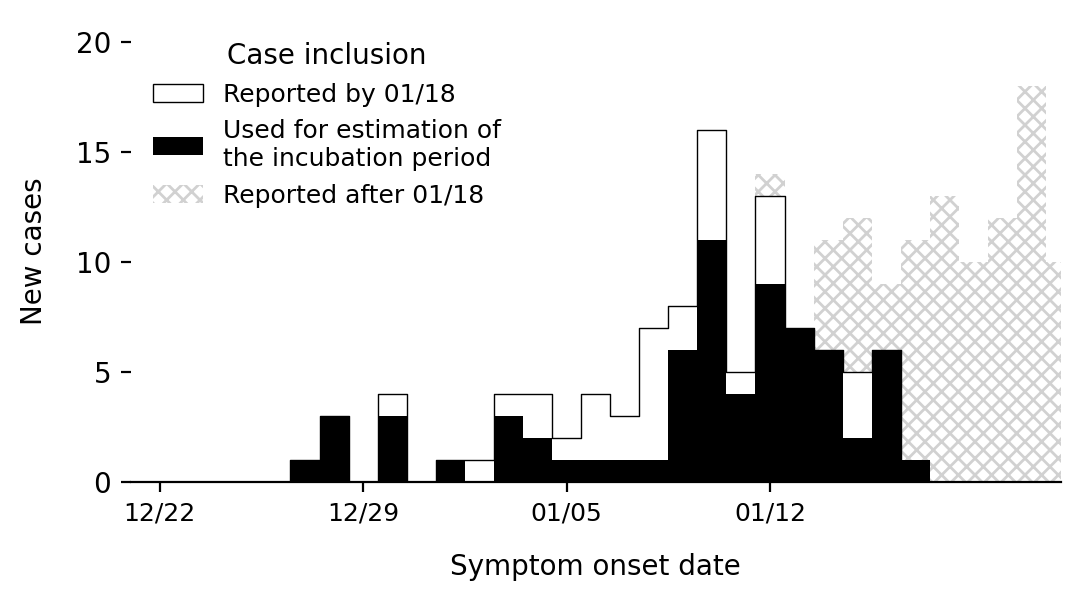

In [87]:
fig, ax = plt.subplots()
fig.set_size_inches(6,3); 

xmax = np.timedelta64(右截斷日_inc - mindate,'D').astype('int64') + 5
xmin = np.timedelta64(datemin_plt - mindate,'D').astype('int64')
bins_number = int(xmax)+2

df_ = df.loc[lambda d: d.確診日 <= 右截斷日_inc].copy()
df_inc_ = df_inc.copy()
df_inc_['發病日期'] = [np.timedelta64(onset - mindate, 'D').astype('int64') for onset in df_inc_.發病日]
df_ext_ = df.copy()

n_, edges = np.histogram(df_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0.5, step='pre', edgecolor='k', facecolor = 'w', label = 'Reported by ' + 右截斷日_inc.strftime("%m/%d"))

n_, edges = np.histogram(df_inc_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0, step='pre', edgecolor='k', facecolor = 'k', label = 'Used for estimation of\nthe incubation period')

n_, _ = np.histogram(df_ext_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-2] + 0.5, [0]*(len(n_)-1), n_[:-1], lw = 0, step='pre', facecolor = 'none', edgecolor='k', alpha=.18, hatch='xxxx', zorder=-4.2, 
                label = 'Reported after ' + 右截斷日_inc.strftime("%m/%d"))

xstep = 5
xtks = np.arange(xmin-3, xmax-5, 7)
ax.set_xticks(xtks)
ax.set_xticklabels([(mindate+np.timedelta64(int(x),'D')).strftime("%m/%d") for x in xtks],fontsize=9);

ax.set_xlabel('Symptom onset date',labelpad=10)
ax.set_ylabel('New cases',labelpad=10)
plt.legend(frameon=False, fontsize=9, ncol=1, title='Case inclusion', title_fontsize=10, loc=2)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.axvline(x=np.timedelta64(右截斷日_inc - mindate, 'D').astype('int64') + 0.5, linestyle='dashed', color='k', linewidth=.8, zorder=15)

plt.axis('tight');
ax.set_yticks(np.arange(0,30,5));
ax.set_ylim(0,21)
ax.set_xlim(xmin-4,xmax-1);

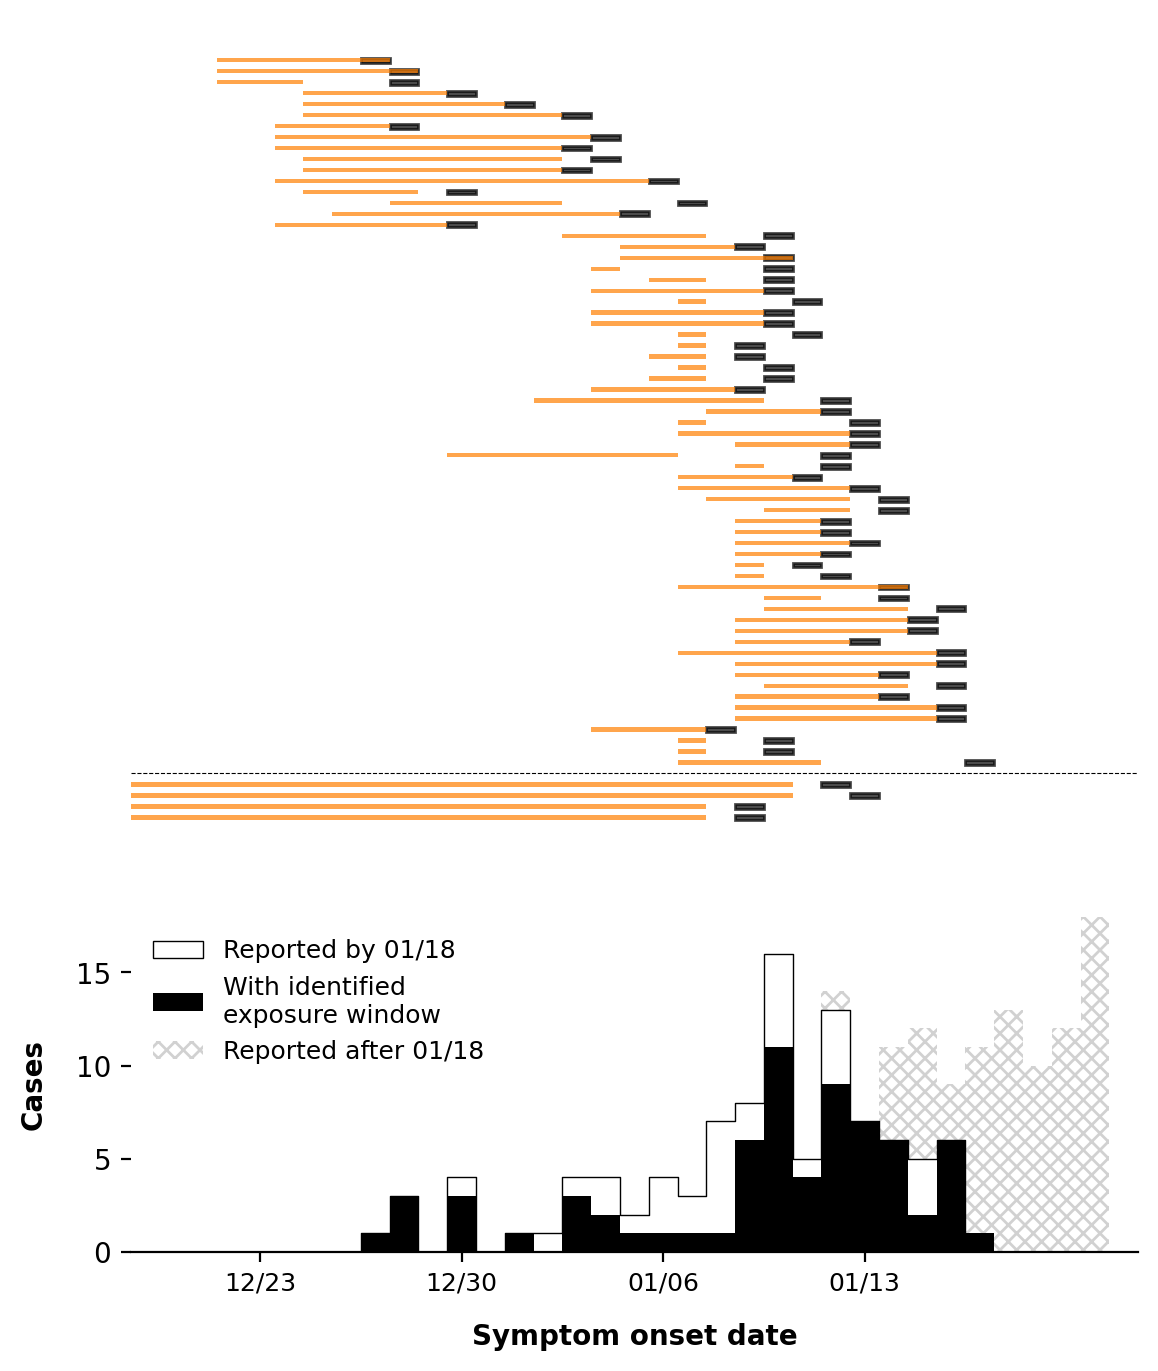

In [135]:
# fig, ax = plt.subplots()
fig, (ax2, ax) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1], 
                                                              'hspace': 0.1})
fig.set_size_inches(6.5,8); 

xmax = np.timedelta64(右截斷日_inc - mindate,'D').astype('int64') + 4
xmin = np.timedelta64(datemin_plt - mindate,'D').astype('int64') - 6

## First subplot
bins_number = int(xmax)+2

df_ = df.loc[lambda d: d.確診日 <= 右截斷日_inc].copy()
df_inc_ = df_inc.copy()
df_inc_['發病日期'] = [np.timedelta64(onset - mindate, 'D').astype('int64') for onset in df_inc_.發病日]
df_ext_ = df.copy()

n_, edges = np.histogram(df_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0.5, step='pre', edgecolor='k', facecolor = 'w', label = 'Reported by ' + 右截斷日_inc.strftime("%m/%d"))

n_, edges = np.histogram(df_inc_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0, step='pre', edgecolor='k', facecolor = 'k', label = 'With identified\nexposure window')

n_, _ = np.histogram(df_ext_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-2] + 0.5, [0]*(len(n_)-1), n_[:-1], lw = 0, step='pre', facecolor = 'none', edgecolor='k', alpha=.18, hatch='xxxx', zorder=-4.2, 
                label = 'Reported after ' + 右截斷日_inc.strftime("%m/%d"))

xstep = 5
xtks = np.arange(xmin-3, xmax-5, 7)
ax.set_xticks(xtks)
ax.set_xticklabels([(mindate+np.timedelta64(int(x),'D')).strftime("%m/%d") for x in xtks],fontsize=9);

ax.set_xlabel('Symptom onset date',labelpad=10)
ax.set_ylabel('Cases',labelpad=10)
plt.legend(frameon=False, fontsize=9, ncol=1, title=None, title_fontsize=9, loc=2)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks(np.arange(0,30,5));
ax.set_ylim(0,21)
ax.margins(0.0)

## Second subplot
df_ = df_inc.copy()#.sort_values('發病日')
for col in ['首次曝光日', '末次曝光日', '發病日']:
    df_[col + '期'] = [np.timedelta64(x - mindate, 'D').astype('int64') if not pd.isnull(x) else xmin for x in df_[col].values]

ystep = 1
yheight = .4
y_ = 0.0
fct_ = 1.1
from matplotlib.patches import Polygon
for idx in range(df_.shape[0]):
    record_ = df_.iloc[idx]
    x_ = record_.發病日期 - .5
    pts = np.array([[x_, y_-fct_*yheight/2], [x_+1,y_-fct_*yheight/2], [x_+1, y_+fct_*yheight/2], [x_, y_+fct_*yheight/2]])
    ax2.add_patch(Polygon(pts, closed=True, color='k', alpha=.7))

    x1_ = record_.首次曝光日期 - .5
    x2_ = record_.末次曝光日期 - .5
    pts = np.array([[x1_, y_-yheight/2], [x2_+1,y_-yheight/2], [x2_+1, y_+yheight/2], [x1_, y_+yheight/2]])
    if idx < N_inc_observed:
        ax2.add_patch(Polygon(pts, closed=True, facecolor='#ff7f00', edgecolor='none', alpha=.7, linewidth=.4))
    else:
        ax2.add_patch(Polygon(pts, closed=False, facecolor='#ff7f00', edgecolor='none', alpha=.7, linewidth=.4))
    if idx == N_inc_observed - 1:
        y_ -= ystep
    y_ -= ystep
    
# ax2.set_xlabel('Symptom onset date',labelpad=10)

ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.axhline(y=-ystep*N_inc_observed, linestyle='dashed', color='k', linewidth=.4, zorder=15)

# ax2.set_xticklabels([])
ax2.tick_params('x', length=0)
ax2.set_yticks([])
ax2.set_xlim(xmin,xmax);

if save_figures:
    plt.savefig("../figures/draft/fig-incper_BA1.pdf", format="pdf", bbox_inches="tight");

plt.axis('tight');

# <font color='orange'>2. Estimating the incubation period</font>

## <font color='green'>2.1. Our dataset from Taiwan</font>

In [19]:
stan_code_inc = """data {
    // number of completely observed records
    int<lower=1> N_inc_obs; 
    // number of right censored records (E_L is unobservable)
    int<lower=0> N_inc_cens;
    vector[N_inc_obs] E_inc_obs_L;
    vector[N_inc_obs + N_inc_cens] E_inc_R, O_inc_L, O_inc_R, // exposure_R and onset dates intervals are all definitive
                                      truncation_day_inc; // truncation day for the incubation period dataset
    int N_vaccinated, N_nonvaccinated;
    array[N_inc_obs + N_inc_cens] int vaccination_status;
                                      
    // for posterior
    int M, M_inc;
    real inc_per_max;
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)

    int N_inc = N_inc_obs + N_inc_cens;
}

parameters {
    vector<lower = 0, upper = 1>[N_inc] exposure_inc_raw, onset_inc_raw;

    // incubation period (we select from one of the distribution: gamma, weibull or lognormal)
    real<lower = 0> mean_inc;
    real<lower=0> param1_weibull_inc;

    vector<lower = 0>[N_inc_cens] negE_inc_cens_L;

    simplex[D] weight; // mixing proportions
}

transformed parameters {
    vector[N_inc_cens] E_inc_cens_L = -negE_inc_cens_L;
    vector[N_inc] E_inc_L = append_row(to_vector(E_inc_obs_L), E_inc_cens_L);

    real<lower = 0> sd_inc; // SD 

    vector[D] param1_inc, param2_inc;
    vector[D] lps = log(weight); // internal component likelihoods 
    {
        vector[N_inc] onset_inc = fma(to_vector(O_inc_R) - to_vector(O_inc_L), onset_inc_raw, to_vector(O_inc_L)), 
            exposure_inc;
        for (k in 1:N_inc) {
            real E_inc_R_ = min({E_inc_R[k], onset_inc[k]}); 
            exposure_inc[k] = fma(E_inc_R_ - E_inc_L[k], exposure_inc_raw[k], E_inc_L[k]);
        }
        vector[N_inc] delay_inc = onset_inc - exposure_inc, sigma_inc = to_vector(truncation_day_inc) + 1 - exposure_inc;

        // Weibull distribution
        param1_inc[2] = param1_weibull_inc;
        param2_inc[2] = mean_inc / tgamma(1.0 + 1.0 / param1_inc[2]); 
        sd_inc = param2_inc[2] * sqrt(tgamma(1.0 + 2.0 / param1_inc[2]) - square(tgamma(1.0 + 1.0 / param1_inc[2])));

        // Gamma distribution
        param1_inc[1] = square(mean_inc / sd_inc);
        param2_inc[1] = mean_inc / square(sd_inc);

        // Lognormal distribution
        param2_inc[3] = sqrt(log(square(sd_inc / mean_inc) + 1.0));
        param1_inc[3] = log(mean_inc) - square(param2_inc[3]) / 2.0;

        // component likelihoods
        lps[1] += gamma_lpdf(delay_inc | param1_inc[1], param2_inc[1]) - gamma_lcdf(sigma_inc | param1_inc[1], param2_inc[1]);
        lps[2] += weibull_lpdf(delay_inc | param1_inc[2], param2_inc[2]) - weibull_lcdf(sigma_inc | param1_inc[2], param2_inc[2]);
        lps[3] += lognormal_lpdf(delay_inc | param1_inc[3], param2_inc[3]) - lognormal_lcdf(sigma_inc | param1_inc[3], param2_inc[3]);
    }
}

model {
    // priors
    mean_inc ~ normal(5, 5);
    param1_weibull_inc ~ gamma(0.01, 0.01);
    exposure_inc_raw ~ uniform(0, 1);
    onset_inc_raw ~ uniform(0, 1);

    negE_inc_cens_L ~ exponential(0.2);

    // likelihood
    target += log_sum_exp(lps);
}

generated quantities {  
    vector<lower = 0, upper = 1>[D] q = exp(lps - log_sum_exp(lps));
    int comp = categorical_rng(q);
    real inc_per;

    if (comp == 2) 
        inc_per = weibull_rng(param1_inc[comp], param2_inc[comp]);
    else if (comp == 1) 
        inc_per = gamma_rng(param1_inc[comp], param2_inc[comp]);
    else if (comp == 3) 
        inc_per = lognormal_rng(param1_inc[comp], param2_inc[comp]);
        
    vector[M_inc] cdf = rep_vector(0.0, M_inc), pdf = rep_vector(0.0, M_inc), x_pdf, x_cdf;
    {
        for (i in 1:M_inc) {
            x_cdf[i] = inc_per_max * i / M_inc;
            if (comp == 2) 
                cdf[i] = weibull_cdf(x_cdf[i] | param1_inc[comp], param2_inc[comp]);
            else if (comp == 1) 
                cdf[i] = gamma_cdf(x_cdf[i] | param1_inc[comp], param2_inc[comp]);
            else if (comp == 3) 
                cdf[i] = lognormal_cdf(x_cdf[i] | param1_inc[comp], param2_inc[comp]);
        }
        pdf[2:M_inc] = tail(cdf, M_inc-1) - head(cdf, M_inc-1);
        pdf[1] = cdf[1];
    }
    x_pdf = x_cdf;
        
    vector[M] ecdf = rep_vector(0.0, M), 
        ecdf_vaccinated = rep_vector(0.0, M), ecdf_nonvaccinated = rep_vector(0.0, M), 
        x_ecdf;
    {
        vector[N_inc] onset_inc = fma(to_vector(O_inc_R) - to_vector(O_inc_L), onset_inc_raw, to_vector(O_inc_L)), 
            exposure_inc;
        for (k in 1:N_inc) {
            real E_inc_R_ = min({E_inc_R[k], onset_inc[k]}); 
            exposure_inc[k] = fma(E_inc_R_ - E_inc_L[k], exposure_inc_raw[k], E_inc_L[k]);
        }
        vector[N_inc] delay_inc = onset_inc - exposure_inc;
        
        for (i in 1:M) {
            x_ecdf[i] = inc_per_max * i / M;
            for (j in 1:N_inc) {
                ecdf[i] += (delay_inc[j] <= x_ecdf[i]); 
                if (vaccination_status[j] == 1)
                    ecdf_vaccinated[i] += (delay_inc[j] <= x_ecdf[i]);
                if (vaccination_status[j] == 0)
                    ecdf_nonvaccinated[i] += (delay_inc[j] <= x_ecdf[i]);
                
            }
            ecdf[i] /= N_inc;
            ecdf_vaccinated[i] /= N_vaccinated;
            ecdf_nonvaccinated[i] /= N_nonvaccinated;
        }
    }
}"""

In [20]:
basename = 右截斷日_inc.strftime("%Y%m%d")+'_incubation_period_no_adjustment-Taiwan'
standirname = os.path.join(mainstandirname, basename)

inc_per_max_ = 12
M_ = 24
M_inc_ = 60

# preparing the data
N_vaccinated_ = df_inc.loc[lambda d: d['vaccination'] == 1].shape[0]
N_nonvaccinated_ = df_inc.loc[lambda d: d['vaccination'] == 0].shape[0]

In [25]:
## Stan program for reporting delay
!rm {standirname}/*
os.makedirs(standirname, exist_ok=True)

stan_data = dict({
    'N_inc_obs': N_inc_observed,
    'N_inc_cens': N_inc_censored,
    'E_inc_obs_L': np.array(df_inc_observed.首次曝光日期.values, dtype='int'), 
    'E_inc_R': np.array(df_inc.末次曝光日期.values, dtype='int') + 1, 
    'O_inc_L': np.array(df_inc.發病日期.values, dtype='int'),  
    'O_inc_R': np.array(df_inc.發病日期.values, dtype='int') + 1, 
    'truncation_day_inc': np.array(df_inc.右截斷日期.values, dtype='int'),
    'M': M_,
    'M_inc': M_inc_,
    'inc_per_max': inc_per_max_,
    'N_vaccinated': N_vaccinated_,
    'N_nonvaccinated': N_nonvaccinated_,
    'vaccination_status': df_inc['vaccination'].values
})
stan_data_file = os.path.join(standirname, 'Data.json')
cmdstan.write_stan_json(stan_data_file, stan_data)

stan_code_file = os.path.join(standirname, 'fit_inc.stan')
with open(stan_code_file, "w+") as f:
    f.write(stan_code_inc)
    f.close()
    
stan_inits = dict({
    'mean_inc': 4.0,
    'param1_weibull_inc': 1.5
})
stan_init_file = os.path.join(standirname, 'Inits.json')
cmdstan.write_stan_json(stan_init_file, stan_inits)

model = cmdstan.CmdStanModel(stan_file=stan_code_file)
fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=num_iterations, inits=stan_init_file,
                   show_console=False, show_progress=True, chains = num_chains) 
fit.save_csvfiles(dir=standirname)

22:30:11 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_no_adjustment-Taiwan/fit_inc.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_no_adjustment-Taiwan/fit_inc
22:30:20 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_no_adjustment-Taiwan/fit_inc
22:30:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:30:47 - cmdstanpy - INFO - CmdStan done processing.
22:30:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_no_adjustment-Taiwan/fit_inc.stan', line 66, column 8 to column 126)
	Exception: grad_reg_lower_inc_gamma: n (internal counter) exceeded 100000 iterations, gamma_p(a,z) gradient (a) did not converge. (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_no_adjustment-Taiwan/fit_inc.stan', line 66, column 8 to column 126)
Exception: gamma_lpdf: Random variable[2] is 0, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_no_adjustment-Taiwan/fit_inc.stan', line 66, column 8 to column 126)
	Exception: grad_reg_lower_inc_gamma: n 

In [29]:
idata = az.from_cmdstanpy(posterior=fit, 
                          posterior_predictive=["x_pdf", "pdf", "x_cdf", "cdf", "ecdf",
                                                "ecdf_nonvaccinated", "ecdf_vaccinated", "x_ecdf"],
                          dtypes={"x_pdf": float, "pdf": float, "x_cdf": float, "cdf": float, "ecdf": float, 
                                  "ecdf_nonvaccinated": float, "ecdf_vaccinated": float, "x_ecdf": float})
df_inc_mean_SD = az.extract_dataset(idata)
ylbs = ['Mean incubation period (days)', 'SD of incubation period (days)']
df_inc_mean_SD = pd.DataFrame({ylbs[0]: df_inc_mean_SD.mean_inc.values, ylbs[1]: df_inc_mean_SD.sd_inc.values}).reset_index()

chart = alt.Chart(df_inc_mean_SD).mark_line(size=.1).encode(
    alt.X('index', title='Iteration'), 
    alt.Y(alt.repeat("column"), scale=alt.Scale(zero=False), type='quantitative')
    ).properties(width=250, height=180
    ).repeat(
        column = ylbs
    ).configure_axis(grid=False)

if save_figures:
    save_chart(chart, '../figures/draft/Fig_inc_per_iterations.svg')

chart

alt.RepeatChart(...)

In [30]:
x_plt_max = 10

df_pdf = get_stats(idata.posterior_predictive, ['pdf', 'x_pdf']).rename(columns={'time':'t', 'q2.5': 'lower', 'q97.5': 'upper'})
x_ = df_pdf.loc[lambda d: d['var']=='x_pdf', 'median'].values
df_pdf = df_pdf.loc[lambda d: d['var']=='pdf']
df_pdf['x'] = x_

df_cdf = get_stats(idata.posterior_predictive, ['cdf', 'x_cdf']).rename(columns={'time':'t', 'q2.5': 'lower', 'q97.5': 'upper'})
x_ = df_cdf.loc[lambda d: d['var']=='x_cdf', 'median'].values
df_cdf = df_cdf.loc[lambda d: d['var']=='cdf']
df_cdf['x'] = x_

base_cdf = alt.Chart(df_cdf.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period (days)'))
median_cdf = base_cdf.mark_line(color='black').encode(alt.Y('median'))
lower_cdf = base_cdf.mark_line(color='black', strokeDash=[8, 6], size=.7).encode(alt.Y('lower'))
upper_cdf = base_cdf.mark_line(color='black', strokeDash=[8, 6], size=.7).encode(alt.Y('upper'))

df_ecdf = get_stats(idata.posterior_predictive, ['ecdf', 'x_ecdf']).rename(columns={'time':'t', 'q2.5': 'lower', 'q97.5': 'upper'})
x_ = df_ecdf.loc[lambda d: d['var']=='x_ecdf', 'median'].values
df_ecdf = df_ecdf.loc[lambda d: d['var']=='ecdf']
df_ecdf['x'] = x_

interpolation_ = 'step'
base_ecdf = alt.Chart(df_ecdf.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period (days)'))
median_ecdf = base_ecdf.mark_line(color='grey', interpolate=interpolation_, strokeDash=[3, 2]).encode(alt.Y('median', title='Cumulative distribution'))
area_ecdf = base_ecdf.mark_area(interpolate=interpolation_, opacity=.2, color='grey', clip=True).encode(alt.Y('lower'),alt.Y2('upper'))
lower_ecdf = base_ecdf.mark_line(color='grey', interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(alt.Y('lower'))
upper_ecdf = base_ecdf.mark_line(color='grey', interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(alt.Y('upper'))

chart = alt.layer(median_ecdf + lower_ecdf + upper_ecdf + area_ecdf, median_cdf + lower_cdf + upper_cdf).properties(width=300, height=200).configure_axis(grid=False)

if save_figures:
    save_chart(chart, '../figures/draft/Fig_inc_per_ecdf_cdf.svg')

chart

alt.LayerChart(...)

In [31]:
clrs_ = ['#d73027', '#4575b4']

df_ecdf_vaccinated = get_stats(idata.posterior_predictive, ['ecdf_vaccinated', 'x_ecdf']).rename(columns={'time':'t', 'q2.5': 'lower', 'q97.5': 'upper'})
x_ = df_ecdf_vaccinated.loc[lambda d: d['var']=='x_ecdf', 'median'].values
df_ecdf_vaccinated = df_ecdf_vaccinated.loc[lambda d: d['var']=='ecdf_vaccinated']
df_ecdf_vaccinated['x'] = x_

interpolation_ = 'step'
base_ecdf = alt.Chart(df_ecdf_vaccinated.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period (days)'))
median_ecdf = base_ecdf.mark_line(color=clrs_[0], interpolate=interpolation_).encode(alt.Y('median', title='Cumulative distribution'))
area_ecdf = base_ecdf.mark_area(interpolate=interpolation_, opacity=.2, color=clrs_[0], clip=True).encode(alt.Y('lower'),alt.Y2('upper'))
lower_ecdf = base_ecdf.mark_line(color=clrs_[0], interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(alt.Y('lower'))
upper_ecdf = base_ecdf.mark_line(color=clrs_[0], interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(alt.Y('upper'))

df_ecdf_nonvaccinated = get_stats(idata.posterior_predictive, ['ecdf_nonvaccinated', 'x_ecdf']).rename(columns={'time':'t', 'q2.5': 'lower', 'q97.5': 'upper'})
x_ = df_ecdf_nonvaccinated.loc[lambda d: d['var']=='x_ecdf', 'median'].values
df_ecdf_nonvaccinated = df_ecdf_nonvaccinated.loc[lambda d: d['var']=='ecdf_nonvaccinated']
df_ecdf_nonvaccinated['x'] = x_

interpolation_ = 'step'
base_ecdf_nonvaccinated = alt.Chart(df_ecdf_nonvaccinated.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period (days)'))
median_ecdf_nonvaccinated = base_ecdf_nonvaccinated.mark_line(color=clrs_[1], interpolate=interpolation_, strokeDash=[3, 2]).encode(alt.Y('median', title='Cumulative distribution'))
area_ecdf_nonvaccinated = base_ecdf_nonvaccinated.mark_area(interpolate=interpolation_, opacity=.2, color=clrs_[1], clip=True).encode(alt.Y('lower'),alt.Y2('upper'))
lower_ecdf_nonvaccinated = base_ecdf_nonvaccinated.mark_line(color=clrs_[1], interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(alt.Y('lower'))
upper_ecdf_nonvaccinated = base_ecdf_nonvaccinated.mark_line(color=clrs_[1], interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(alt.Y('upper'))


chart = alt.layer(median_ecdf_nonvaccinated + lower_ecdf_nonvaccinated + upper_ecdf_nonvaccinated + area_ecdf_nonvaccinated, 
                  median_ecdf + lower_ecdf + upper_ecdf + area_ecdf).properties(width=300, height=200).configure_axis(grid=False)

if save_figures:
    save_chart(chart, '../figures/draft/Fig_inc_per_ecdf_vaccinated_and_nonvaccinated-variant_1.svg')

chart

alt.LayerChart(...)

In [32]:
mod_inc_summary_output = get_stats(idata.posterior, ['mean_inc', 'sd_inc', 'inc_per', 'q'])
mod_inc_summary_output['Mean (95% CI) [95th percentile]'] = ["%.2f (%.2f-%.2f) [%.2f]" % (x, y, z, w) for (x,y,z,w) in zip(mod_inc_summary_output['mean'], mod_inc_summary_output['q2.5'], mod_inc_summary_output['q97.5'], mod_inc_summary_output['q95'])]
mod_inc_summary_output['Parameter'] = ['Mean incubation period, days', 'SD, days', 'Posterior incubation period, days', 'Pr(gamma)', 'Pr(Weibull)', 'Pr(lognormal)']

mod_inc_summary_output.loc[lambda d: ~d.Parameter.str.contains("Pr\("), ['Parameter', 'Mean (95% CI) [95th percentile]']]

Parameter Mean (95% CI) [95th percentile]
0       Mean incubation period, days         3.53 (3.08-4.00) [3.92]
1                           SD, days         1.22 (0.85-1.81) [1.68]
2  Posterior incubation period, days         3.53 (1.58-6.52) [5.81]

In [33]:
# Selection among three distributions (lognormal appears to be more plausible)
mod_inc_summary_output.loc[lambda d: d.Parameter.str.contains("Pr\("), ['Parameter', 'Mean (95% CI) [95th percentile]']]

Parameter Mean (95% CI) [95th percentile]
3      Pr(gamma)         0.30 (0.00-0.95) [0.90]
4    Pr(Weibull)         0.04 (0.00-0.57) [0.23]
5  Pr(lognormal)         0.65 (0.00-1.00) [0.99]

## <font color='green'>2.2. Ancestral strain. Data from Wuhan, China (Linton et al 2020)</font>

In [34]:
%%R -i mainstandirname -o df_both_obs -o 右截斷日期
libraries = c("dplyr")  
for(x in libraries) { suppressMessages(library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)) }

R.Version()$version.string

stanmaindir = mainstandirname
右截斷日 = as.Date("2020-01-31") # right truncation date
mindate = as.Date("2019-12-01")

右截斷日期 = as.numeric(右截斷日 - mindate)

df_inc = read.csv('../../data/data_inc_per_Wuhan_Linton_et_al_JCM2020.csv')  |>
    select(id, exp_l, exp_r, onset, hosp) |>
    # here I translate some columns to Chinese, so it will be correspondent to the code for Taiwan_Omicron
    rename(案號 = id, 首次曝光日 = exp_l, 末次曝光日 = exp_r, 發病日 = onset, 住院治療日 = hosp) |>
    mutate(across(contains("日"), ~as.Date(., format="%Y-%m-%d"))) |>
    # if the onset is not given, then its right end is assigned to the hospitalization date, its left end to the right exposure date
    mutate(首發病日 = if_else(is.na(發病日), 首次曝光日, 發病日), 末發病日 = if_else(is.na(發病日), 住院治療日, 發病日)) |> 
    # if the right exposure is not given, then it is assinged to the right onset date
    mutate(末次曝光日 = if_else(is.na(末次曝光日), 末發病日, 末次曝光日)) |> 
    # lastly, if the right exposure date is later than the right onset date, then it is assigned to the right onset date
    mutate(末次曝光日 = if_else(末次曝光日 > 末發病日, 末發病日, 末次曝光日)) |> 
    # expressing date as days from mindate
    mutate(首次曝光日期 = as.numeric(首次曝光日 - mindate), 末次曝光日期 = as.numeric(末次曝光日 - mindate), 
           首發病日期 = as.numeric(首發病日 - mindate), 末發病日期 = as.numeric(末發病日 - mindate)) |>
    # if exp_r is NA or it is later then the onset date, we assign it to the left onset because it is the data among travellers from Wuhan
    mutate(末次曝光日期 = if_else(末次曝光日期 >= 首發病日期 | is.na(末次曝光日期), 首發病日期, 末次曝光日期)) 
print(paste0("Number of records: ", nrow(df_inc)))
df_both_obs = df_inc |> filter(!is.na(首次曝光日), !is.na(末次曝光日))
df_obs_first = df_inc |> filter(!is.na(首次曝光日), is.na(末次曝光日))
df_obs_last = df_inc |> filter(is.na(首次曝光日), !is.na(末次曝光日))
print(paste0("Censored dfs are empty: nrow(df_obs_first) = ", nrow(df_obs_first), " and nrow(df_obs_last) = ", nrow(df_obs_last)))

[1] "Number of records: 52"
[1] "Censored dfs are empty: nrow(df_obs_first) = 0 and nrow(df_obs_last) = 0"


In [35]:
右截斷日 = pd.to_datetime("2020-01-31", format="%Y-%m-%d")

In [36]:
右截斷日期 = 右截斷日期.astype('int64')[0]
右截斷日期

61

In [37]:
stan_code = """functions {
    // suppose that onset and exposure times are both distributed uniformly between O_L and O_R, and E_L and E_R, respectively
    // then the incubation period would be the difference between these two and it would be given by trapezoidal distribution
    // see Reich et al 2009 https://doi.org/10.1002/sim.3659 for details, esp. Figure 1
    real trapezoidal_lpdf(real z_raw, real E_L, real E_R, real O_L, real O_R) { 
        real res;
        if (O_L < E_R)
            res = 1.0 / ((O_R - O_L) * (E_R - E_L) - 0.5 * square(E_R - O_L)); 
        else
            res = 1.0 / (O_R - O_L) / (E_R - E_L);
        real zmin = max({O_L - E_R, 0}),
             z = fma(O_R - E_L - zmin, z_raw, zmin);

        // now we calculate the pdf according to Figure 1 from Reich et al
        // however, the form of the distribution would depend on relative lenght of the intervals for exposure and onset
        // ps: Reich et al only showed the result for O_R - O_L < E_R - E_L in Figure 1
        if ((O_R - O_L) < (E_R - E_L))
            res *= (z >= O_L - E_L) ? (O_R - E_L - z) : ((z >= O_R - E_R) ? (O_R - O_L) : z - O_L + E_R);
        else
            res *= (z >= O_R - E_R) ? (O_R - E_L - z) : ((z >= O_L - E_L) ? (E_R - E_L) : z - O_L + E_R);

        return log(res); // log because it is a log-pdf
    }
}

data {
    // all records are not left censored (= constain the E_L date)
    int<lower=1> N; 
    array[N] int E_L, E_R, O_L, O_R;
    
    int<lower = max(O_R)> truncation_day; // truncation day

    // for generated quantities
    int M;
    real xmax;
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)
}

parameters {
    vector<lower = 0, upper = 1>[N] delay_raw;

    // incubation period (we select from one of the distribution: gamma, weibull or lognormal
    real<lower = 0> mean_inc;
    real<lower=0> param1_weibull_inc;

    simplex[D] weight; // mixing proportions
}

transformed parameters {
    // transforming delay_raw to actual delay
    vector[N] delay;
    for (k in 1:N) {
        real delay_lower = max({O_L[k] - E_R[k], 0});
        delay[k] = fma(O_R[k] - E_L[k] - delay_lower,  delay_raw[k], delay_lower);
    }
    real<lower = 0> sd_inc; // SD 

    vector[D] param1, param2;
    vector[D] lps = log(weight); // internal component likelihoods 
    {
        // Weibull distribution
        param1[2] = param1_weibull_inc;
        param2[2] = mean_inc / tgamma(1.0 + 1.0 / param1[2]); 
        sd_inc = param2[2] * sqrt(tgamma(1.0 + 2.0 / param1[2]) - square(tgamma(1.0 + 1.0 / param1[2])));

        // Gamma distribution
        param1[1] = square(mean_inc / sd_inc);
        param2[1] = mean_inc / square(sd_inc);

        // Lognormal distribution
        param2[3] = sqrt(log(square(sd_inc / mean_inc) + 1.0));
        param1[3] = log(mean_inc) - square(param2[3]) / 2.0;

        // component likelihoods
        lps[1] += gamma_lpdf(delay | param1[1], param2[1]) 
                  - gamma_lcdf(truncation_day - to_vector(E_L) + 1 | param1[1], param2[1]);
        lps[2] += weibull_lpdf(delay | param1[2], param2[2]) 
                  - weibull_lcdf(truncation_day - to_vector(E_L) + 1  | param1[2], param2[2]);
        lps[3] += lognormal_lpdf(delay | param1[3], param2[3])  
                  - lognormal_lcdf(truncation_day - to_vector(E_L) + 1 | param1[3], param2[3]);
    }
}


model {
  // priors
  mean_inc ~ normal(5, 5);
  param1_weibull_inc ~ gamma(0.01, 0.01);
  for (k in 1:N) 
    target += trapezoidal_lpdf(delay_raw[k] | E_L[k], E_R[k], O_L[k], O_R[k]);

  // likelihood
  target += log_sum_exp(lps);
}

generated quantities {  
    vector<lower = 0, upper = 1>[D] q = exp(lps - log_sum_exp(lps));
    int comp = categorical_rng(q);

    vector[M] pdf, x_pdf;
    {
        vector[M] y = rep_vector(0.0, M);
        for (i in 1:M) {
            x_pdf[i] = xmax * i / M;
            y[i] = (comp == 1) ? gamma_cdf(x_pdf[i] | param1[comp], param2[comp]) : 
                         ((comp == 2) ? weibull_cdf(x_pdf[i] | param1[comp], param2[comp]) : lognormal_cdf(x_pdf[i] | param1[comp], param2[comp]));
        }
        pdf[2:M] = tail(y, M-1) - head(y, M-1);
        pdf[1] = y[1];
    }
}"""

In [38]:
basename = 右截斷日.strftime("%Y%m%d")+'_incubation_period_right_truncation-Wuhan'
standirname = os.path.join(mainstandirname, basename)

## Stan program for reporting delay
!rm {standirname}/*
os.makedirs(standirname, exist_ok=True)

stan_data = dict({
    'N': df_both_obs.shape[0],
    'E_L': np.array(df_both_obs.首次曝光日期.values, dtype='int'),
    'E_R': np.array(df_both_obs.首次曝光日期.values, dtype='int') + 1,
    'O_L': np.array(df_both_obs.首發病日期.values, dtype='int'),  
    'O_R': np.array(df_both_obs.末發病日期.values, dtype='int') + 1, 
    'truncation_day': 右截斷日期,
    'M': M_inc_,
    'xmax': inc_per_max_,
    'N_vaccinated': N_vaccinated_,
})
stan_data_file = os.path.join(standirname, 'Data.json')
cmdstan.write_stan_json(stan_data_file, stan_data)

stan_code_file = os.path.join(standirname, 'fit_inc.stan')
with open(stan_code_file, "w+") as f:
    f.write(stan_code)
    f.close()
    
stan_inits = dict({
    'mean_inc': 4.0,
    'param1_weibull_inc': 1.5
})
stan_init_file = os.path.join(standirname, 'Inits.json')
cmdstan.write_stan_json(stan_init_file, stan_inits)

model_Wuhan = cmdstan.CmdStanModel(stan_file=stan_code_file)
fit_Wuhan = model_Wuhan.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=num_iterations, inits=stan_init_file,
                   show_console=False, show_progress=True, chains = num_chains) 
fit_Wuhan.save_csvfiles(dir=standirname)

22:34:02 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20200131_incubation_period_right_truncation-Wuhan/fit_inc.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20200131_incubation_period_right_truncation-Wuhan/fit_inc
22:34:12 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20200131_incubation_period_right_truncation-Wuhan/fit_inc
22:34:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:34:27 - cmdstanpy - INFO - CmdStan done processing.
22:34:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20200131_incubation_period_right_truncation-Wuhan/fit_inc.stan', line 78, column 8 to line 79, column 91)
	Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20200131_incubation_period_right_truncation-Wuhan/fit_inc.stan', line 78, column 8 to line 79, column 91)
	Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20200131_incubation_period_right_truncation-Wuhan/fit_inc.stan', line 78, column 8 to line 79, column 91)
	Exception: gamma_lpdf: Shape parameter is nan, but must be posi

In [39]:
idata_Wuhan = az.from_cmdstanpy(posterior=fit_Wuhan,
    posterior_predictive=["x_pdf", "pdf"],
    dtypes={"x_pdf": float, "pdf": float})

df_pdf_Wuhan = get_stats(idata_Wuhan.posterior_predictive, ['pdf', 'x_pdf']).rename(columns={'time':'t', 'q2.5': 'lower', 'q97.5': 'upper'})
x_ = df_pdf_Wuhan.loc[lambda d: d['var']=='x_pdf', 'median'].values
df_pdf_Wuhan = df_pdf_Wuhan.loc[lambda d: d['var']=='pdf']
df_pdf_Wuhan['x'] = x_

In [40]:
x_plt_max = 12

clr_Present = '#cb181d'
interpolation_ = 'natural'
base_pdf = alt.Chart(df_pdf.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period (days)'))
median_pdf = base_pdf.mark_line(color=clr_Present, interpolate=interpolation_).encode(alt.Y('median'))
lower_pdf = base_pdf.mark_line(color=clr_Present, size=.3, interpolate=interpolation_).encode(alt.Y('lower'))
upper_pdf = base_pdf.mark_line(color=clr_Present, size=.3, interpolate=interpolation_).encode(alt.Y('upper'))
area_pdf = base_pdf.mark_area(interpolate=interpolation_, opacity=.1, color=clr_Present, clip=True).encode(alt.Y('lower'),alt.Y2('upper'))

clr_Wuhan = 'grey'
base_pdf_Wuhan = alt.Chart(df_pdf_Wuhan.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period (days)'))
median_pdf_Wuhan = base_pdf_Wuhan.mark_line(color=clr_Wuhan, strokeDash=[4, 3], interpolate=interpolation_).encode(alt.Y('median', title='Probability density'))
lower_pdf_Wuhan = base_pdf_Wuhan.mark_line(color=clr_Wuhan, size=.3, interpolate=interpolation_).encode(alt.Y('lower'))
upper_pdf_Wuhan = base_pdf_Wuhan.mark_line(color=clr_Wuhan, size=.3, interpolate=interpolation_).encode(alt.Y('upper'))
area_pdf_Wuhan = base_pdf_Wuhan.mark_area(interpolate=interpolation_, opacity=.1, color=clr_Wuhan, clip=True).encode(alt.Y('lower'),alt.Y2('upper'))

chart = alt.layer(area_pdf_Wuhan + median_pdf_Wuhan + lower_pdf_Wuhan + upper_pdf_Wuhan, 
                  area_pdf + median_pdf + lower_pdf + upper_pdf).properties(width=320, height=200).configure_axis(grid=False)

if save_figures:
    save_chart(chart, '../figures/draft/Fig_inc_pdf.svg')

chart

alt.LayerChart(...)

## <font color='green'>2.3. Subgroup analysis</font>

### Incubation period by vaccination

In [41]:
stan_code_inc_vac = """data {
    // number of completely observed records
    int<lower=1> N_inc_obs; 
    // number of right censored records (E_L is unobservable)
    int<lower=0> N_inc_cens;
    vector[N_inc_obs] E_inc_obs_L;
    vector[N_inc_obs + N_inc_cens] E_inc_R, O_inc_L, O_inc_R, // exposure_R and onset dates intervals are all definitive
                                      truncation_day_inc; // truncation day for the incubation period dataset
    int N_vaccinated, N_nonvaccinated;
    array[N_inc_obs + N_inc_cens] int vaccination_status;
                          
    // for posterior
    int M, M_inc;
    real inc_per_max;
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)

    int N_inc = N_inc_obs + N_inc_cens;
}

parameters {
    vector<lower = 0, upper = 1>[N_inc] exposure_inc_raw, onset_inc_raw;

    // incubation period (we select from one of the distribution: gamma, weibull or lognormal
    array[2] real<lower = 0> mean_inc, param1_weibull_inc;

    vector<lower = 0>[N_inc_cens] negE_inc_cens_L;

    array[2] simplex[D] weight; // mixing proportions
}

transformed parameters {
    vector[N_inc_cens] E_inc_cens_L = -negE_inc_cens_L;
    vector[N_inc] E_inc_L = append_row(to_vector(E_inc_obs_L), E_inc_cens_L);
    
    array[2] real<lower = 0> sd_inc; // SD 

    array[2] vector[D] param1_inc, param2_inc;
    array[2] vector[D] lps;
    for (j in 1:2) 
        lps[j] = log(weight[j]); // internal component likelihoods 
    {
        vector[N_inc] onset_inc = fma(to_vector(O_inc_R) - to_vector(O_inc_L), onset_inc_raw, to_vector(O_inc_L)), 
            exposure_inc;
        for (k in 1:N_inc) {
            real E_inc_R_ = min({E_inc_R[k], onset_inc[k]}); 
            exposure_inc[k] = fma(E_inc_R_ - E_inc_L[k], exposure_inc_raw[k], E_inc_L[k]);
        }
        vector[N_inc] delay_inc = onset_inc - exposure_inc, sigma_inc = to_vector(truncation_day_inc) + 1 - exposure_inc;

        for (j in 1:2) {
            // Weibull distribution
            param1_inc[j, 2] = param1_weibull_inc[j];
            param2_inc[j, 2] = mean_inc[j] / tgamma(1.0 + 1.0 / param1_inc[j, 2]); 
            sd_inc[j] = param2_inc[j, 2] * sqrt(tgamma(1.0 + 2.0 / param1_inc[j, 2]) - square(tgamma(1.0 + 1.0 / param1_inc[j, 2])));

            // Gamma distribution
            param1_inc[j, 1] = square(mean_inc[j] / sd_inc[j]);
            param2_inc[j, 1] = mean_inc[j] / square(sd_inc[j]);

            // Lognormal distribution
            param2_inc[j, 3] = sqrt(log(square(sd_inc[j] / mean_inc[j]) + 1.0));
            param1_inc[j, 3] = log(mean_inc[j]) - square(param2_inc[j, 3]) / 2.0;
        }
        
        // component likelihoods
        for (k in 1:N_inc) {
            int j_ = (vaccination_status[k] == 1) ? 2 : 1;
            lps[j_, 1] += gamma_lpdf(delay_inc[k] | param1_inc[j_, 1], param2_inc[j_, 1]) - gamma_lcdf(sigma_inc[k] | param1_inc[j_, 1], param2_inc[j_, 1]);
            lps[j_, 2] += weibull_lpdf(delay_inc[k] | param1_inc[j_, 2], param2_inc[j_, 2]) - weibull_lcdf(sigma_inc[k] | param1_inc[j_, 2], param2_inc[j_, 2]);
            lps[j_, 3] += lognormal_lpdf(delay_inc[k] | param1_inc[j_, 3], param2_inc[j_, 3]) - lognormal_lcdf(sigma_inc[k] | param1_inc[j_, 3], param2_inc[j_, 3]);
        }
    }
}

model {
    // priors
    mean_inc ~ std_normal();
    param1_weibull_inc ~ exponential(0.01);
    exposure_inc_raw ~ uniform(0, 1);
    onset_inc_raw ~ uniform(0, 1);

    negE_inc_cens_L ~ exponential(0.1);

    // likelihood
    for (j in 1:2)
        target += log_sum_exp(lps[j]);
}

generated quantities {  
    array[2] vector<lower = 0, upper = 1>[D] q;
    array[2] int comp;
    for (j in 1:2) {
        q[j] = exp(lps[j] - log_sum_exp(lps[j]));
        comp[j] = categorical_rng(q[j]); 
    }
    array[2] real inc_per;

    for (j in 1:2) {
        if (comp[j] == 2) 
            inc_per[j] = weibull_rng(param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
        else if (comp[j] == 1) 
            inc_per[j] = gamma_rng(param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
        else if (comp[j] == 3) 
            inc_per[j] = lognormal_rng(param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
    }
        
    array[2] vector[M_inc] cdf; 
    vector[M_inc] x_cdf;
    for (j in 1:2)
        cdf[j] = rep_vector(0.0, M_inc);
    {
        for (i in 1:M_inc) {
            x_cdf[i] = inc_per_max * i / M_inc;
            for (j in 1:2) {
                if (comp[j] == 2) 
                    cdf[j, i] = weibull_cdf(x_cdf[i] | param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
                else if (comp[j] == 1) 
                    cdf[j, i] = gamma_cdf(x_cdf[i] | param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
                else if (comp[j] == 3) 
                    cdf[j, i] = lognormal_cdf(x_cdf[i] | param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
            }
        }
    }
        
    array[2] vector[M] ecdf;
    vector[M] x_ecdf;
    for (j in 1:2)
        ecdf[j] = rep_vector(0.0, M);
    {
        vector[N_inc] onset_inc = fma(to_vector(O_inc_R) - to_vector(O_inc_L), onset_inc_raw, to_vector(O_inc_L)), 
            exposure_inc;
        for (k in 1:N_inc) {
            real E_inc_R_ = min({E_inc_R[k], onset_inc[k]}); 
            exposure_inc[k] = fma(E_inc_R_ - E_inc_L[k], exposure_inc_raw[k], E_inc_L[k]);
        }
        vector[N_inc] delay_inc = onset_inc - exposure_inc;
        
        for (i in 1:M) {
            x_ecdf[i] = inc_per_max * i / M;
            for (k in 1:N_inc) {
                int j_ = (vaccination_status[k] == 1) ? 2 : 1;
                ecdf[j_, i] += (delay_inc[k] <= x_ecdf[i]);
            }
            ecdf[1, i] /= N_nonvaccinated;
            ecdf[2, i] /= N_vaccinated;
        }
    }
}"""

In [42]:
basename = 右截斷日_inc.strftime("%Y%m%d")+'_incubation_period_vac-Taiwan'
standirname = os.path.join(mainstandirname, basename)

# preparing the data
df_inc_ = pd.concat([df_inc_observed, df_inc_censored], ignore_index=True).loc[lambda d: d['vaccination']!=-1]
N_vaccinated_ = df_inc_.loc[lambda d: d['vaccination'] == 1].shape[0]
N_nonvaccinated_ = df_inc_.loc[lambda d: d['vaccination'] == 0].shape[0]
print([N_vaccinated_, N_nonvaccinated_])

# completely observed
N_inc_observed_ = df_inc_.loc[lambda d: (~pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))].shape[0]
# right censored
N_inc_censored_ = df_inc_.loc[lambda d: (pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))].shape[0]
print([N_inc_observed_, N_inc_censored_])

[40, 16]
[53, 3]


In [43]:
## Stan program for reporting delay
!rm {standirname}/*
os.makedirs(standirname, exist_ok=True)

stan_data = dict({
    'N_inc_obs': N_inc_observed_,
    'N_inc_cens': N_inc_censored_,
    'E_inc_obs_L': np.array(df_inc_.loc[lambda d: (~pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))].首次曝光日期.values, dtype='int'), 
    'E_inc_R': np.array(df_inc_.末次曝光日期.values, dtype='int') + 1, 
    'O_inc_L': np.array(df_inc_.發病日期.values, dtype='int'),  
    'O_inc_R': np.array(df_inc_.發病日期.values, dtype='int') + 1, 
    'truncation_day_inc': np.array(df_inc_.右截斷日期.values, dtype='int'),
    'M': M_,
    'M_inc': M_inc_,
    'inc_per_max': inc_per_max_,
    'N_vaccinated': N_vaccinated_,
    'N_nonvaccinated': N_nonvaccinated_,
    'vaccination_status': df_inc_['vaccination'].values
})
stan_data_file = os.path.join(standirname, 'Data.json')
cmdstan.write_stan_json(stan_data_file, stan_data)

stan_code_file = os.path.join(standirname, 'fit_inc.stan')
with open(stan_code_file, "w+") as f:
    f.write(stan_code_inc_vac)
    f.close()

stan_inits = dict({
    'mean_inc': [4.0, 4.0],
    'param1_weibull_inc': [1.5, 1.5]
})
stan_init_file = os.path.join(standirname, 'Inits.json')
cmdstan.write_stan_json(stan_init_file, stan_inits)

model = cmdstan.CmdStanModel(stan_file=stan_code_file)
fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=num_iterations, inits=stan_init_file, show_console=False, chains = num_chains) #
fit.save_csvfiles(dir=standirname)

22:34:59 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_vac-Taiwan/fit_inc.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_vac-Taiwan/fit_inc
22:35:11 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_vac-Taiwan/fit_inc
22:35:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:35:45 - cmdstanpy - INFO - CmdStan done processing.
22:35:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: grad_reg_lower_inc_gamma: n (internal counter) exceeded 100000 iterations, gamma_p(a,z) gradient (a) did not converge. (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_vac-Taiwan/fit_inc.stan', line 71, column 12 to column 156)
	Exception: grad_reg_lower_inc_gamma: n (internal counter) exceeded 100000 iterations, gamma_p(a,z) gradient (a) did not converge. (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_vac-Taiwan/fit_inc.stan', line 71, column 12 to column 156)
	Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_vac-Taiwan/fit_inc.stan', line 71, column 12 to column 156)
	Exception: g

In [44]:
idata = az.from_cmdstanpy(posterior=fit)
az.summary(idata, var_names=['mean_inc', 'sd_inc', 'inc_per'], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mean_inc[0]  3.510  0.459     2.612      4.405      0.003    0.002   24884.0   
mean_inc[1]  3.069  0.269     2.531      3.585      0.002    0.001   19299.0   
sd_inc[0]    1.449  0.448     0.726      2.356      0.003    0.002   17987.0   
sd_inc[1]    1.060  0.230     0.650      1.509      0.002    0.001   13396.0   
inc_per[0]   3.506  1.578     0.574      6.381      0.007    0.005   43808.0   
inc_per[1]   3.063  1.121     1.074      5.274      0.005    0.004   44497.0   

             ess_tail  r_hat  
mean_inc[0]   28390.0    1.0  
mean_inc[1]   26568.0    1.0  
sd_inc[0]     29298.0    1.0  
sd_inc[1]     26911.0    1.0  
inc_per[0]    43016.0    1.0  
inc_per[1]    42244.0    1.0

In [45]:
df_ecdf_vaccinated = get_stats_2d(idata.posterior, ['ecdf'])#.rename(columns={'time':'t', 'q2.5': 'lower', 'q97.5': 'upper'})
df_ecdf_vaccinated[['vaccination', 'time']] = df_ecdf_vaccinated['time'].str.split(',', expand=True).astype('int')
df_ecdf_vaccinated['time'] += 1
df_ecdf_vaccinated = df_ecdf_vaccinated.merge(get_stats(idata.posterior, ['x_ecdf']).loc[:, ['time', 'mean']]\
        .rename(columns = {'mean':'x'})).rename(columns = {'q2.5':'lower', 'q97.5':'upper'})
df_ecdf_vaccinated['cases'] = [N_vaccinated_ if vaccination==1 else N_nonvaccinated_ for vaccination in df_ecdf_vaccinated['vaccination']]
df_ecdf_vaccinated['status'] = [f'Vaccinated [{cases}]' if vaccination==1 else f'Non-vaccinated [{cases}]' for vaccination, cases in zip(df_ecdf_vaccinated['vaccination'], df_ecdf_vaccinated['cases'])]
df_ecdf_vaccinated[:5]

var  time  mean  hdi2.5  hdi25  hdi75  hdi97.5  lower  q25  median   q75  \
0  ecdf     1  0.00     0.0    0.0    0.0     0.00    0.0  0.0     0.0  0.00   
1  ecdf     1  0.00     0.0    0.0    0.0     0.00    0.0  0.0     0.0  0.00   
2  ecdf     2  0.01     0.0    0.0    0.0     0.06    0.0  0.0     0.0  0.00   
3  ecdf     2  0.00     0.0    0.0    0.0     0.02    0.0  0.0     0.0  0.00   
4  ecdf     3  0.04     0.0    0.0    0.0     0.19    0.0  0.0     0.0  0.06   

   upper  ess_bulk  ess_tail  r_hat  vaccination    x  cases  \
0   0.00  30785.07  31028.95    1.0            0  0.5     16   
1   0.00  35413.37  35392.35    1.0            1  0.5     40   
2   0.12  18346.87  19187.58    1.0            0  1.0     16   
3   0.05  13647.36  14601.74    1.0            1  1.0     40   
4   0.19  14665.53  16384.72    1.0            0  1.5     16   

                status  
0  Non-vaccinated [16]  
1      Vaccinated [40]  
2  Non-vaccinated [16]  
3      Vaccinated [40]  
4  Non-vaccinated [16]

### Incubation period by age group

In [46]:
clrs_ = ['#d73027', '#4575b4']

interpolation_ = 'step'
base_ecdf = alt.Chart(df_ecdf_vaccinated.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period (days)'),
    alt.Color('status:N', legend=alt.Legend(
        orient='none', title = 'Status [# cases]',
        legendX=186, legendY=40,
        direction='vertical',
        titleAnchor='middle'))
)
median_ecdf = base_ecdf.mark_line(interpolate=interpolation_).encode(
    alt.Y('median', title='Cumulative distribution'))
area_ecdf = base_ecdf.mark_area(interpolate=interpolation_, opacity=.2, clip=True).encode(
    alt.Y('lower'),alt.Y2('upper'))
lower_ecdf = base_ecdf.mark_line(interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(
    alt.Y('lower'))
upper_ecdf = base_ecdf.mark_line(interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(
    alt.Y('upper'))

chart = (median_ecdf + lower_ecdf + upper_ecdf + area_ecdf).properties(width=300, height=200).configure_axis(grid=False)

if save_figures:
    save_chart(chart, '../figures/draft/Fig_inc_per_ecdf_vaccinated_and_nonvaccinated.svg') #

chart

alt.LayerChart(...)

### Incubation period by age group

In [47]:
stan_code_inc_age = """data {
    // number of completely observed records
    int<lower=1> N_inc_obs; 
    // number of right censored records (E_L is unobservable)
    int<lower=0> N_inc_cens;
    vector[N_inc_obs] E_inc_obs_L;
    vector[N_inc_obs + N_inc_cens] E_inc_R, O_inc_L, O_inc_R, // exposure_R and onset dates intervals are all definitive
                                      truncation_day_inc; // truncation day for the incubation period dataset
    int A; // number of age groups
    array[N_inc_obs + N_inc_cens] int<lower = 1, upper = A> age_group;
                     
    // for posterior
    int M, M_inc;
    real inc_per_max;
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)

    int N_inc = N_inc_obs + N_inc_cens;
    
    array[A] int N_subgroup = rep_array(0, A);
    for (k in 1:N_inc)
        N_subgroup[age_group[k]] += 1;
}

parameters {
    vector<lower = 0, upper = 1>[N_inc] exposure_inc_raw, onset_inc_raw;

    // incubation period (we select from one of the distribution: gamma, weibull or lognormal
    array[A] real<lower = 0> mean_inc, param1_weibull_inc;

    vector<lower = 0>[N_inc_cens] negE_inc_cens_L;

    array[A] simplex[D] weight; // mixing proportions
}

transformed parameters {
    vector[N_inc_cens] E_inc_cens_L = -negE_inc_cens_L;
    vector[N_inc] E_inc_L = append_row(to_vector(E_inc_obs_L), E_inc_cens_L);

    array[A] real<lower = 0> sd_inc; // SD 

    array[A] vector[D] param1_inc, param2_inc;
    array[A] vector[D] lps;
    for (j in 1:A) 
        lps[j] = log(weight[j]); // internal component likelihoods 
    {
        vector[N_inc] onset_inc = fma(to_vector(O_inc_R) - to_vector(O_inc_L), onset_inc_raw, to_vector(O_inc_L)), 
            exposure_inc;
        for (k in 1:N_inc) {
            real E_inc_R_ = min({E_inc_R[k], onset_inc[k]}); 
            exposure_inc[k] = fma(E_inc_R_ - E_inc_L[k], exposure_inc_raw[k], E_inc_L[k]);
        }
        vector[N_inc] delay_inc = onset_inc - exposure_inc, sigma_inc = to_vector(truncation_day_inc) + 1 - exposure_inc;

        for (j in 1:A) {
            // Weibull distribution
            param1_inc[j, 2] = param1_weibull_inc[j];
            param2_inc[j, 2] = mean_inc[j] / tgamma(1.0 + 1.0 / param1_inc[j, 2]); 
            sd_inc[j] = param2_inc[j, 2] * sqrt(tgamma(1.0 + 2.0 / param1_inc[j, 2]) - square(tgamma(1.0 + 1.0 / param1_inc[j, 2])));

            // Gamma distribution
            param1_inc[j, 1] = square(mean_inc[j] / sd_inc[j]);
            param2_inc[j, 1] = mean_inc[j] / square(sd_inc[j]);

            // Lognormal distribution
            param2_inc[j, 3] = sqrt(log(square(sd_inc[j] / mean_inc[j]) + 1.0));
            param1_inc[j, 3] = log(mean_inc[j]) - square(param2_inc[j, 3]) / 2.0;
        }
        
        // component likelihoods
        for (k in 1:N_inc) {
            int j_ = age_group[k];
            lps[j_, 1] += gamma_lpdf(delay_inc[k] | param1_inc[j_, 1], param2_inc[j_, 1]) - gamma_lcdf(sigma_inc[k] | param1_inc[j_, 1], param2_inc[j_, 1]);
            lps[j_, 2] += weibull_lpdf(delay_inc[k] | param1_inc[j_, 2], param2_inc[j_, 2]) - weibull_lcdf(sigma_inc[k] | param1_inc[j_, 2], param2_inc[j_, 2]);
            lps[j_, 3] += lognormal_lpdf(delay_inc[k] | param1_inc[j_, 3], param2_inc[j_, 3]) - lognormal_lcdf(sigma_inc[k] | param1_inc[j_, 3], param2_inc[j_, 3]);
        }
    }
}

model {
    // priors
    mean_inc ~ std_normal();
    param1_weibull_inc ~ exponential(0.01);
    exposure_inc_raw ~ uniform(0, 1);
    onset_inc_raw ~ uniform(0, 1);

    negE_inc_cens_L ~ exponential(0.2);

    // likelihood
    for (j in 1:A)
        target += log_sum_exp(lps[j]);
}

generated quantities {  
    array[A] vector<lower = 0, upper = 1>[D] q;
    array[A] int comp;
    for (j in 1:A) {
        q[j] = exp(lps[j] - log_sum_exp(lps[j]));
        comp[j] = categorical_rng(q[j]); 
    }
    array[A] real inc_per;

    for (j in 1:A) {
        if (comp[j] == 2) 
            inc_per[j] = weibull_rng(param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
        else if (comp[j] == 1) 
            inc_per[j] = gamma_rng(param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
        else if (comp[j] == 3) 
            inc_per[j] = lognormal_rng(param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
    }
        
    array[A] vector[M_inc] cdf; 
    vector[M_inc] x_cdf;
    for (j in 1:A)
        cdf[j] = rep_vector(0.0, M_inc);
    {
        for (i in 1:M_inc) {
            x_cdf[i] = inc_per_max * i / M_inc;
            for (j in 1:A) {
                if (comp[j] == 2) 
                    cdf[j, i] = weibull_cdf(x_cdf[i] | param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
                else if (comp[j] == 1) 
                    cdf[j, i] = gamma_cdf(x_cdf[i] | param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
                else if (comp[j] == 3) 
                    cdf[j, i] = lognormal_cdf(x_cdf[i] | param1_inc[j, comp[j]], param2_inc[j, comp[j]]);
            }
        }
    }
        
    array[A] vector[M] ecdf;
    vector[M] x_ecdf;
    for (j in 1:A)
        ecdf[j] = rep_vector(0.0, M);
    {
        vector[N_inc] onset_inc = fma(to_vector(O_inc_R) - to_vector(O_inc_L), onset_inc_raw, to_vector(O_inc_L)), 
            exposure_inc;
        for (k in 1:N_inc) {
            real E_inc_R_ = min({E_inc_R[k], onset_inc[k]}); 
            exposure_inc[k] = fma(E_inc_R_ - E_inc_L[k], exposure_inc_raw[k], E_inc_L[k]);
        }
        vector[N_inc] delay_inc = onset_inc - exposure_inc;
        
        for (i in 1:M) {
            x_ecdf[i] = inc_per_max * i / M;
            for (k in 1:N_inc) {
                int j_ = age_group[k];
                ecdf[j_, i] += (delay_inc[k] <= x_ecdf[i]);
            }
            for (j in 1:A)
                ecdf[j, i] /= N_subgroup[j];
        }
    }
}"""

In [50]:
df_ages = pd.DataFrame({'年齡': df_inc['年齡'].drop_duplicates().values})
df_ages['年齡lower'] = [x[:-1] if '+' in x else x.split('-')[0] for x in df_ages['年齡']]
df_ages = df_ages.sort_values('年齡lower').reset_index(drop=True).reset_index().rename(columns={'index':'年齡期'})
df_ages['年齡期'] += 1
df_ages

年齡期     年齡 年齡lower
0    1   0-17       0
1    2  18-49      18
2    3    50+      50

In [51]:
basename = 右截斷日_inc.strftime("%Y%m%d")+'_incubation_period_age-Taiwan'
standirname = os.path.join(mainstandirname, basename)
outputfile_parquet = os.path.join('results', basename+'.parquet.gzip')
outputfile_iterations_parquet = os.path.join('results', basename+'_iterations.parquet.gzip')

df_inc_ = pd.concat([df_inc_observed, df_inc_censored], ignore_index=True)
df_inc_ = df_inc_.merge(df_ages, on='年齡', how='left')
df_inc_.groupby('年齡')['年齡'].count()

年齡
0-17      8
18-49    45
50+      16
Name: 年齡, dtype: int64

In [52]:
# completely observed
N_inc_observed_ = df_inc_.loc[lambda d: (~pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))].shape[0]
# right censored
N_inc_censored_ = df_inc_.loc[lambda d: (pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))].shape[0]
print([N_inc_observed_, N_inc_censored_])

[65, 4]


In [54]:
## Stan program for reporting delay
!rm {standirname}/*
os.makedirs(standirname, exist_ok=True)

stan_data = dict({
    'N_inc_obs': N_inc_observed_,
    'N_inc_cens': N_inc_censored_,
    'E_inc_obs_L': np.array(df_inc_.loc[lambda d: (~pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))].首次曝光日期.values, dtype='int'), 
    'E_inc_R': np.array(df_inc_.末次曝光日期.values, dtype='int') + 1, 
    'O_inc_L': np.array(df_inc_.發病日期.values, dtype='int'),  
    'O_inc_R': np.array(df_inc_.發病日期.values, dtype='int') + 1, 
    'truncation_day_inc': np.array(df_inc_.右截斷日期.values, dtype='int'),
    'M': M_,
    'M_inc': M_inc_,
    'inc_per_max': inc_per_max_,
    'A': len(df_ages),
    'age_group': df_inc_['年齡期'].values
})
stan_data_file = os.path.join(standirname, 'Data.json')
cmdstan.write_stan_json(stan_data_file, stan_data)

stan_code_file = os.path.join(standirname, 'fit_inc.stan')
with open(stan_code_file, "w+") as f:
    f.write(stan_code_inc_age)
    f.close()

model = cmdstan.CmdStanModel(stan_file=stan_code_file)
fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=num_iterations, show_console=False, chains = num_chains) #
fit.save_csvfiles(dir=standirname)

22:41:34 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_age-Taiwan/fit_inc.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_age-Taiwan/fit_inc
22:41:45 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_age-Taiwan/fit_inc
22:41:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:42:44 - cmdstanpy - INFO - CmdStan done processing.
22:42:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_age-Taiwan/fit_inc.stan', line 75, column 12 to column 156)
	Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_age-Taiwan/fit_inc.stan', line 75, column 12 to column 156)
	Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/20220118_incubation_period_age-Taiwan/fit_inc.stan', line 75, column 12 to column 156)
	Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '/Users/andrei/Library/CloudStorage/Drop

22:42:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.0%)
	Chain 3 had 1 divergent transitions (0.0%)
	Use function "diagnose()" to see further information.


In [55]:
idata = az.from_cmdstanpy(posterior=fit)
az.summary(idata, var_names=['mean_inc', 'sd_inc', 'inc_per'], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mean_inc[0]  2.624  0.602     1.494      3.834      0.004    0.003   20956.0   
mean_inc[1]  3.173  0.210     2.756      3.583      0.001    0.001   19811.0   
mean_inc[2]  3.036  0.522     2.027      4.063      0.004    0.003   18754.0   
sd_inc[0]    1.444  0.583     0.579      2.540      0.004    0.003   24858.0   
sd_inc[1]    0.857  0.181     0.536      1.218      0.002    0.001   11483.0   
sd_inc[2]    1.635  0.527     0.787      2.677      0.004    0.003   17086.0   
inc_per[0]   2.618  1.639     0.019      5.466      0.008    0.006   38235.0   
inc_per[1]   3.176  0.901     1.502      4.972      0.004    0.003   46204.0   
inc_per[2]   3.041  1.810     0.190      6.312      0.009    0.006   37006.0   

             ess_tail  r_hat  
mean_inc[0]   28495.0    1.0  
mean_inc[1]   26603.0    1.0  
mean_inc[2]   25759.0    1.0  
sd_inc[0]     30230.0    1.0  
sd_inc[1]     24025.0    1.0  
sd_inc[2]     25173.0    1.0  
inc_per[0]    43764.0    1.0  
inc_per[1]    43763.0    1.0  
inc_per[2]    41212.0    1.0

In [341]:
df_inc_counts = df_inc_.groupby('age_group')['age_group'].count().values

for i in range(len(bins)-1):
    if i == len(bins) - 2:
        age_group_ = f'{bins[i]}+'
    else:
        age_group_ = f'{bins[i]}-{bins[i+1]-1}'
    age_group_ += f' [{df_inc_counts[i]}]'
    print(age_group_)
    age_groups = np.array([age_group_]) if i==0 else np.r_[age_groups, [age_group_]]
df_ecdf_['age_group_str'] = [age_groups[i-1] for i in df_ecdf_['age_group']] 

0-17 [10]
18-49 [45]
50+ [15]


In [57]:
df_ecdf_ = get_stats_2d(idata.posterior, ['ecdf'])
df_ecdf_[['年齡期', 'time']] = df_ecdf_['time'].str.split(',', expand=True).astype('int')
df_ecdf_['年齡期'] += 1
df_ecdf_['time'] += 1
df_ecdf_ = df_ecdf_.merge(get_stats(idata.posterior, ['x_ecdf']).loc[:, ['time', 'mean']]\
        .rename(columns = {'mean':'x'})).rename(columns = {'q2.5':'lower', 'q97.5':'upper'})
df_ecdf_ = df_ecdf_.merge(df_ages, on='年齡期', how='left')
df_ecdf_[:5]

var  time  mean  hdi2.5  hdi25  hdi75  hdi97.5  lower  q25  median   q75  \
0  ecdf     1  0.01     0.0    0.0    0.0     0.12    0.0  0.0     0.0  0.00   
1  ecdf     1  0.00     0.0    0.0    0.0     0.00    0.0  0.0     0.0  0.00   
2  ecdf     1  0.01     0.0    0.0    0.0     0.06    0.0  0.0     0.0  0.00   
3  ecdf     2  0.06     0.0    0.0    0.0     0.25    0.0  0.0     0.0  0.12   
4  ecdf     2  0.00     0.0    0.0    0.0     0.00    0.0  0.0     0.0  0.00   

   upper  ess_bulk  ess_tail  r_hat  年齡期    x     年齡 年齡lower  
0   0.12  25393.82  26059.41    1.0    1  0.5   0-17       0  
1   0.00  33047.55  33113.55    1.0    2  0.5  18-49      18  
2   0.06  18957.58  19778.01    1.0    3  0.5    50+      50  
3   0.38  17617.35  18900.79    1.0    1  1.0   0-17       0  
4   0.02  16814.64  17326.39    1.0    2  1.0  18-49      18

In [76]:
df_inc_counts = df_inc_.groupby('年齡')['案號'].count().reset_index().rename(columns={'案號':'count'})
df_inc_counts['年齡str'] = [f'{年齡} [{count}]' for 年齡,count in zip(df_inc_counts['年齡'], df_inc_counts['count'])]
# df_ecdf_['年齡str'] = [age_groups[i-1] for i in df_ecdf_['年齡']] 
df_ecdf_ = df_ecdf_.merge(df_inc_counts, on = '年齡', how='left')

In [136]:
interpolation_ = 'step'
lb_ = ['Age [# cases]']
base_ecdf = alt.Chart(df_ecdf_.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period (days)'),
    alt.Color('年齡str:N', legend=alt.Legend(
        orient='none', title=lb_,
        legendX=220, legendY=40,
        direction='vertical',
        titleAnchor='middle'))
)
median_ecdf = base_ecdf.mark_line(interpolate=interpolation_).encode(
    alt.Y('median', title='Cumulative distribution'))
area_ecdf = base_ecdf.mark_area(interpolate=interpolation_, opacity=.2, clip=True).encode(
    alt.Y('lower'),alt.Y2('upper'))
lower_ecdf = base_ecdf.mark_line(interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(
    alt.Y('lower'))
upper_ecdf = base_ecdf.mark_line(interpolate=interpolation_, strokeDash=[4, 3], size=.3).encode(
    alt.Y('upper'))

chart = (median_ecdf + lower_ecdf + upper_ecdf + area_ecdf).properties(width=300, height=200).configure_axis(grid=False)

if save_figures:
    save_chart(chart, '../figures/draft/Fig_inc_per_age_group.svg')

chart

alt.LayerChart(...)

# <font color='orange'>3. Systematic search and meta-analysis</font>

In [93]:
!ls ../data/csv-Omicron-incper_PUBMED*

../data/csv-Omicron-incper_PUBMED.csv
../data/csv-Omicron-incper_PUBMED_broad.csv
../data/csv-Omicron-incper_PUBMED_broad.xlsx


In [94]:
df_inc_review = pd.read_excel('../../data/csv-Omicron-incper_PUBMED_broad.xlsx').reset_index(drop=True)
df_inc_review.columns

Index(['No', 'PMID', 'Title', 'Authors', 'Citation', 'First Author',
       'Journal/Book', 'Publication Year', 'Create Date', 'DOI',
       'Estimated incubation period', 'Exclusion', 'Subvariant', 'Mean',
       'Mean_lower', 'Mean_upper', 'Lower', 'Upper', 'SD', 'CohortSize'],
      dtype='object')

In [96]:
print(colored(f"Total number of records: {df_inc_review.No.drop_duplicates().shape[0]}", 'blue'))
print(colored(f"Deemed unrelated: {df_inc_review.loc[lambda d: (d['Estimated incubation period']=='No')&(pd.isnull(d['Exclusion']))].shape[0]}", 'blue'))

Total number of records: 110
Deemed unrelated: 85


In [98]:
print(colored('Reasons for exclusion', 'blue'))
exclusion_reasons = df_inc_review.loc[lambda d: ~pd.isnull(d['Exclusion'])]['Exclusion'].drop_duplicates().values
df_inc_review.loc[lambda d: ~pd.isnull(d['Exclusion'])].groupby('Exclusion')['Exclusion'].count()

Reasons for exclusion


Exclusion
Not in English                  8
Review                          2
Values not explicitly stated    2
Name: Exclusion, dtype: int64

In [106]:
print(colored(f"Analyzed studies: {df_inc_review.loc[lambda d: (d['Estimated incubation period']=='Yes')&(pd.isnull(d['Exclusion']))].No.drop_duplicates().shape[0]} publications", 'blue'))
print(colored(f"which resulted in {df_inc_review.loc[lambda d: (d['Estimated incubation period']=='Yes')&(pd.isnull(d['Exclusion']))].shape[0]} records", 'blue'))

Analyzed studies: 13 publications
which resulted in 15 records


In [107]:
df_inc_review.loc[lambda d: (d['Estimated incubation period']=='Yes')&(pd.isnull(d['Exclusion']))].groupby('Subvariant')['Subvariant'].count()

Subvariant
BA.1      9
BA.1/2    1
BA.2      3
BA.5      2
Name: Subvariant, dtype: int64

In [110]:
df_inc_review_analyzed = df_inc_review.copy().loc[lambda d: (d['Estimated incubation period']=='Yes')&(pd.isnull(d['Exclusion']))].reset_index(drop=True)
df_inc_review_analyzed['Study'] = [x.split(' ')[0] + ' et al. ' + str(y) for x, y in zip(df_inc_review_analyzed['First Author'], df_inc_review_analyzed['Publication Year'])]
df_inc_review_analyzed = df_inc_review_analyzed.loc[:, ['Study', 'Create Date', 'Subvariant', 'Mean', 'Mean_lower', 'Mean_upper', 'SD', 'CohortSize']]
df_inc_review_analyzed['Mean_lower'] = [mean_lower if ~np.isnan(mean_lower) else mean - 1.96 * sd for mean, mean_lower, sd in zip(df_inc_review_analyzed['Mean'], df_inc_review_analyzed['Mean_lower'], df_inc_review_analyzed['SD'])]
df_inc_review_analyzed['Mean_upper'] = [mean_upper if ~np.isnan(mean_upper) else mean + 1.96 * sd for mean, mean_upper, sd in zip(df_inc_review_analyzed['Mean'], df_inc_review_analyzed['Mean_upper'], df_inc_review_analyzed['SD'])]
df_inc_review_analyzed['Mean_stderr'] = [(mean_upper - mean_lower) / 1.96 / np.sqrt(N) / 2 for mean_lower, mean_upper, N in zip(df_inc_review_analyzed['Mean_lower'], df_inc_review_analyzed['Mean_upper'], df_inc_review_analyzed['CohortSize'])]
df_inc_review_analyzed['Mean_stderr_from_SD'] = [sd / np.sqrt(N) for sd, N in zip(df_inc_review_analyzed['SD'], df_inc_review_analyzed['CohortSize'])]
df_inc_review_analyzed

Study Create Date Subvariant  Mean  Mean_lower  Mean_upper  \
0    Russell et al. 2023  2023-06-09       BA.1  4.90      4.2000      5.5000   
1    Russell et al. 2023  2023-06-09       BA.2  4.40      3.2000      5.5000   
2        Lyu et al. 2023  2023-05-26       BA.2  5.26      5.2100      5.3100   
3       Park et al. 2023  2023-05-22       BA.1  4.20      3.6000      4.9000   
4   Galmiche et al. 2023  2023-04-21       BA.1  3.58      3.5200      3.6500   
5       Wang et al. 2023  2023-03-30       BA.5  5.70      4.8000      6.6000   
6        Guo et al. 2023  2023-03-09     BA.1/2  3.40      2.9000      4.0000   
7       Zeng et al. 2023  2023-03-06       BA.1  2.80      0.8000      7.0000   
8        Wei et al. 2023  2023-02-27       BA.2  4.60      0.4840      8.7160   
9      Ogata et al. 2023  2023-02-14       BA.5  2.60      2.5000      2.8000   
10     Ogata et al. 2023  2023-02-14       BA.1  2.90      2.6000      3.2000   
11       Xin et al. 2023  2022-12-13       BA.1  3.80      3.5000      4.1000   
12    Manica et al. 2022  2022-07-06       BA.1  3.49      3.1900      3.7700   
13    Tanaka et al. 2022  2022-05-28       BA.1  3.07      2.0606      4.0794   
14    Backer et al. 2022  2022-02-11       BA.1  3.20      2.9000      3.6000   

       SD  CohortSize  Mean_stderr  Mean_stderr_from_SD  
0     NaN         NaN          NaN                  NaN  
1     NaN         NaN          NaN                  NaN  
2     NaN        57.0     0.003379                  NaN  
3     NaN       258.0     0.020647                  NaN  
4   1.770      2682.0     0.000640             0.034178  
5     NaN        60.0     0.059280                  NaN  
6     NaN       649.0     0.011015                  NaN  
7     NaN        36.0     0.263605                  NaN  
8   2.100        52.0     0.291218             0.291218  
9     NaN       122.0     0.006929                  NaN  
10    NaN        68.0     0.018561                  NaN  
11    NaN       114.0     0.014335                  NaN  
12  1.200        80.0     0.016542             0.134164  
13  0.515        77.0     0.058690             0.058690  
14  2.200       258.0     0.011117             0.136966

In [111]:
df_inc_review_analyzed.columns

Index(['Study', 'Create Date', 'Subvariant', 'Mean', 'Mean_lower',
       'Mean_upper', 'SD', 'CohortSize', 'Mean_stderr', 'Mean_stderr_from_SD'],
      dtype='object')

In [112]:
print(colored(f"Insufficient information: {df_inc_review_analyzed.loc[lambda d: np.isnan(d.Mean_stderr)].shape[0]}", 'blue'))

Insufficient information: 2


In [129]:
df_ = df_inc_review_analyzed.loc[lambda d: d.Subvariant=='BA.1'].copy()
weight_total = np.sum(df_.Weight)
df_['Mean_weighted'] = [weight * mu / weight_total for weight, mu in zip(df_.Weight, df_.Mean)]
df_

Study Create Date Subvariant  Mean  Mean_lower  Mean_upper  \
3       Park et al. 2023  2023-05-22       BA.1  4.20      3.6000      4.9000   
4   Galmiche et al. 2023  2023-04-21       BA.1  3.58      3.5200      3.6500   
7       Zeng et al. 2023  2023-03-06       BA.1  2.80      0.8000      7.0000   
10     Ogata et al. 2023  2023-02-14       BA.1  2.90      2.6000      3.2000   
11       Xin et al. 2023  2022-12-13       BA.1  3.80      3.5000      4.1000   
12    Manica et al. 2022  2022-07-06       BA.1  3.49      3.1900      3.7700   
13    Tanaka et al. 2022  2022-05-28       BA.1  3.07      2.0606      4.0794   
14    Backer et al. 2022  2022-02-11       BA.1  3.20      2.9000      3.6000   

       SD  CohortSize  Mean_stderr  Mean_stderr_from_SD        Weight  \
3     NaN         258     0.020647                  NaN  2.345876e+03   
4   1.770        2682     0.000640             0.034178  2.438620e+06   
7     NaN          36     0.263605                  NaN  1.439101e+01   
10    NaN          68     0.018561                  NaN  2.902542e+03   
11    NaN         114     0.014335                  NaN  4.866027e+03   
12  1.200          80     0.016542             0.134164  3.654316e+03   
13  0.515          77     0.058690             0.058690  2.903195e+02   
14  2.200         258     0.011117             0.136966  8.090880e+03   

    Mean_weighted  
3        0.004004  
4        3.547755  
7        0.000016  
10       0.003421  
11       0.007514  
12       0.005183  
13       0.000362  
14       0.010521

In [114]:
df_inc_review_analyzed = df_inc_review_analyzed.loc[lambda d: ~np.isnan(d.Mean_stderr)].copy()
df_inc_review_analyzed['CohortSize'] = df_inc_review_analyzed['CohortSize'].astype('int64')
df_inc_review_analyzed

Study Create Date Subvariant  Mean  Mean_lower  Mean_upper  \
2        Lyu et al. 2023  2023-05-26       BA.2  5.26      5.2100      5.3100   
3       Park et al. 2023  2023-05-22       BA.1  4.20      3.6000      4.9000   
4   Galmiche et al. 2023  2023-04-21       BA.1  3.58      3.5200      3.6500   
5       Wang et al. 2023  2023-03-30       BA.5  5.70      4.8000      6.6000   
6        Guo et al. 2023  2023-03-09     BA.1/2  3.40      2.9000      4.0000   
7       Zeng et al. 2023  2023-03-06       BA.1  2.80      0.8000      7.0000   
8        Wei et al. 2023  2023-02-27       BA.2  4.60      0.4840      8.7160   
9      Ogata et al. 2023  2023-02-14       BA.5  2.60      2.5000      2.8000   
10     Ogata et al. 2023  2023-02-14       BA.1  2.90      2.6000      3.2000   
11       Xin et al. 2023  2022-12-13       BA.1  3.80      3.5000      4.1000   
12    Manica et al. 2022  2022-07-06       BA.1  3.49      3.1900      3.7700   
13    Tanaka et al. 2022  2022-05-28       BA.1  3.07      2.0606      4.0794   
14    Backer et al. 2022  2022-02-11       BA.1  3.20      2.9000      3.6000   

       SD  CohortSize  Mean_stderr  Mean_stderr_from_SD  
2     NaN          57     0.003379                  NaN  
3     NaN         258     0.020647                  NaN  
4   1.770        2682     0.000640             0.034178  
5     NaN          60     0.059280                  NaN  
6     NaN         649     0.011015                  NaN  
7     NaN          36     0.263605                  NaN  
8   2.100          52     0.291218             0.291218  
9     NaN         122     0.006929                  NaN  
10    NaN          68     0.018561                  NaN  
11    NaN         114     0.014335                  NaN  
12  1.200          80     0.016542             0.134164  
13  0.515          77     0.058690             0.058690  
14  2.200         258     0.011117             0.136966

In [117]:
stan_code_meta_summary = """data {
  int<lower=1> J;  // number of studies with available data
  vector[J] mu_known;  // means of known studies
  vector<lower=0>[J] stderr_known;  // standard errors of known studies
}

parameters {
  real<lower=0> mu;
  real<lower=0> tau;
}

model {
  // Priors
  mu ~ normal(4, 8);  // weakly informative prior for the overall mean
  tau ~ cauchy(0, 5);  // weakly informative prior for the between-study variability

  // Likelihood
  mu_known ~ normal(mu, sqrt(square(stderr_known) + square(tau)));
}

generated quantities {
  real mu_pred, tau_squared;

    {
        // Calculate tau-squared statistic
        tau_squared = square(tau);

        // Predict a future observation for a hypothetical new study
        mu_pred = normal_rng(mu, sqrt(tau));
    }
}"""

basename = 'incper_BA1_meta_summary'
standirname = os.path.join(mainstandirname, basename)

!rm {standirname}/*
os.makedirs(standirname, exist_ok=True)

        
stan_code_file = os.path.join(standirname, 'fit_incper_meta.stan')
with open(stan_code_file, "w+") as f:
    f.write(stan_code_meta_summary)
    f.close()

df_ = df_inc_review_analyzed.loc[lambda d: d.Subvariant=='BA.1'].copy()
    
stan_data = dict({
    'J': df_.shape[0],
    'mu_known': df_['Mean'].values,
    'stderr_known': df_['Mean_stderr'].values
})
stan_data_file = os.path.join(standirname, 'Data.json')
cmdstan.write_stan_json(stan_data_file, stan_data)
    
model = cmdstan.CmdStanModel(stan_file=stan_code_file)
fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=num_iterations, 
                   inits=stan_init_file, show_console=False, chains = num_chains) #
fit.save_csvfiles(dir=standirname)

zsh:1: no matches found: ../../../Taiwan_Backup/Taiwan-Omicron_incper_2023/incper_BA1_meta_summary/*


23:29:33 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/incper_BA1_meta_summary/fit_incper_meta.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/incper_BA1_meta_summary/fit_incper_meta
23:29:37 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/incper_BA1_meta_summary/fit_incper_meta
23:29:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:29:38 - cmdstanpy - INFO - CmdStan done processing.
23:29:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/incper_BA1_meta_summary/fit_incper_meta.stan', line 18, column 2 to column 66)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/incper_BA1_meta_summary/fit_incper_meta.stan', line 18, column 2 to column 66)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_incper_2023/incper_BA1_meta_summary/fit_incper_meta.stan', line 18, column 2 to column 66)
Consider re-running with show_console=True if the above output is unclear!


In [128]:
idata_meta = az.from_cmdstanpy(posterior=fit)
df_meta_incper_BA1_summary = get_stats(idata_meta.posterior, varnames=['mu', 'tau', 'mu_pred', 'tau_squared'])\
    .rename(columns={'q2.5':'lower', 'q97.5':'upper'})
df_meta_incper_BA1_summary

var time     mean   hdi2.5    hdi25    hdi75  hdi97.5    lower  \
0           mu   NA  3.39560  2.95265  3.28392  3.53984  3.82153  2.95006   
1          tau   NA  0.57387  0.27272  0.37562  0.57972  0.98050  0.31333   
2      mu_pred   NA  3.39481  1.82931  2.88123  3.90465  4.93953  1.83269   
3  tau_squared   NA  0.37360  0.05925  0.10955  0.29766  0.93031  0.09817   

       q25   median      q75      q95    upper     ess_bulk     ess_tail  \
0  3.26954  3.39818  3.52628  3.73562  3.81978  21954.85054  16914.36391   
1  0.43287  0.52777  0.66126  0.96206  1.10044  19839.65382  20826.03378   
2  2.88504  3.39718  3.90917  4.68519  4.94503  43704.97799  42704.07114   
3  0.18737  0.27854  0.43726  0.92556  1.21097  19839.64665  20826.03378   

     r_hat  
0  1.00004  
1  1.00005  
2  0.99998  
3  1.00005

In [124]:
mu_incper_current_study = df_inc_mean_SD['Mean incubation period (days)'].values
mean_current_study = np.mean(mu_incper_current_study)
mean_lower_current_study, mean_upper_current_study = np.percentile(mu_incper_current_study, [2.5, 97.5])
print(mean_current_study, mean_lower_current_study, mean_upper_current_study)

3.5266796034000003 3.0816165 4.004031


In [125]:
df_current_study = pd.DataFrame({'mu': [mean_current_study], 'mu_lower': [mean_lower_current_study], 'mu_upper': [mean_upper_current_study]})
df_current_study['Source'] = 'Present study'
df_current_study['CohortSize'] = N_inc
df_current_study

mu  mu_lower  mu_upper         Source  CohortSize
0  3.52668  3.081616  4.004031  Present study          69

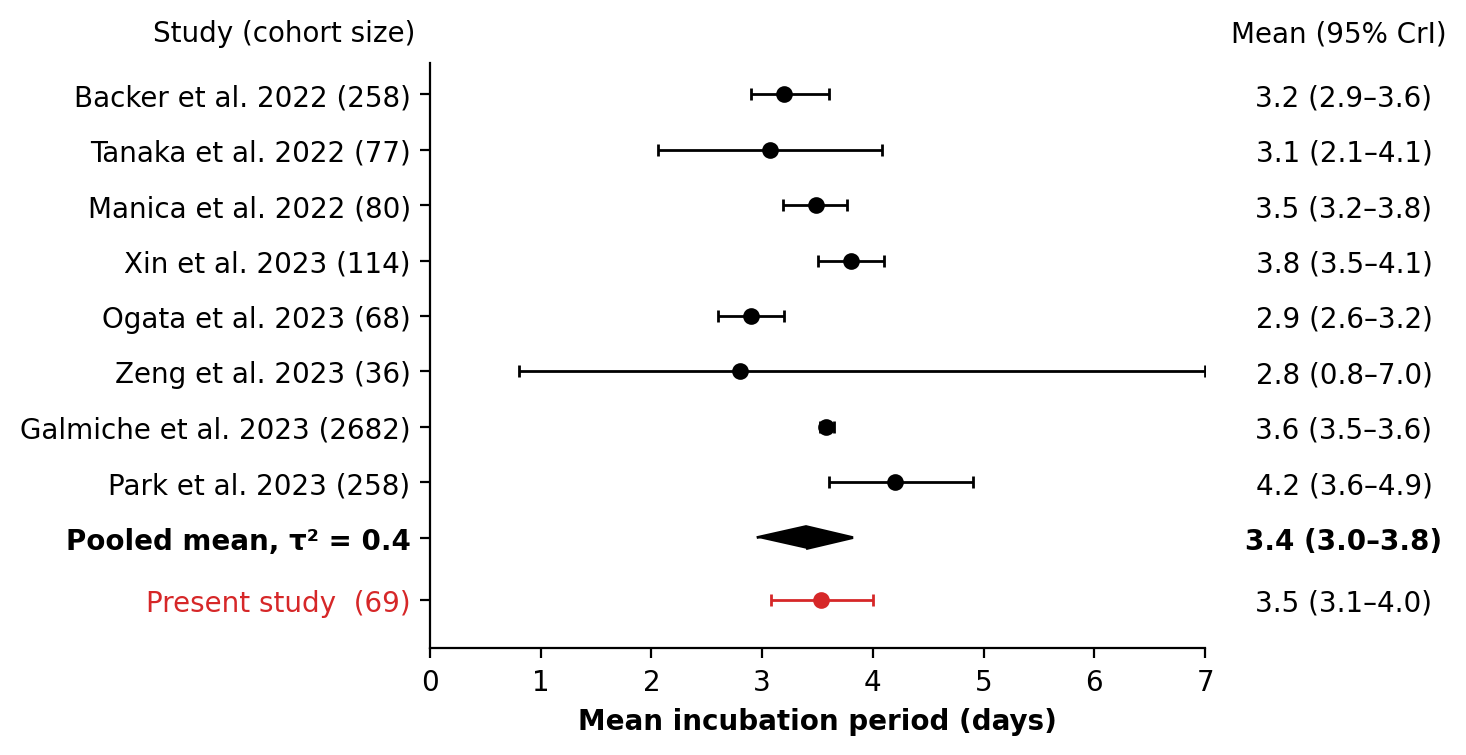

In [137]:
# for presentation
fig = plt.figure(figsize = [5, 3.8])  #, dpi = 300
ax1 = fig.add_subplot()

df_ = df_inc_review_analyzed.loc[lambda d: d.Subvariant=='BA.1'].copy()

df_['Source'] = df_['Study']
df_['Source'] = [x + ' (' + str(z) + ')' for x,z in zip(df_['Study'], df_['CohortSize'])]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax1.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Mean_lower']), list(df_['Mean_upper'] - df_['Mean'])], color='black', capsize=2,
             linestyle='None', linewidth=1, markersize=0)
ax1.plot(list(df_['Mean']), df_['Source_y'], color='black', mfc='k', 
         linestyle='None', linewidth=1, marker="o", ms=5)

# Pooled mean
mean_meta = df_meta_incper_BA1_summary.loc[lambda d: d['var']=='mu', 'mean'].values[0]
lower_meta = df_meta_incper_BA1_summary.loc[lambda d: d['var']=='mu', 'lower'].values[0]
upper_meta = df_meta_incper_BA1_summary.loc[lambda d: d['var']=='mu', 'upper'].values[0]
τsqr_meta = df_meta_incper_BA1_summary.loc[lambda d: d['var']=='tau_squared', 'mean'].values[0]
y_ = 0.0
h_ = 0.2/df_.shape[0]
from matplotlib.patches import Polygon
pts = np.array([[lower_meta, y_], [mean_meta,y_+h_], [upper_meta, y_], [mean_meta, y_-h_], [lower_meta, y_]])
p = Polygon(pts, closed=False, color='k')
ax1.add_patch(p)

## current study
df__ = df_current_study.copy()
df__['Source'] = [x + '  (' + str(z) + ')' for x,z in zip(df__['Source'], df__['CohortSize'])]

y__ = -0.14
clr_ = 'C3'

ax1.errorbar(x=list(df__['mu']), y=y__, 
             xerr=[list(df__['mu'] - df__['mu_lower']), list(df__['mu_upper'] - df__['mu'])], color=clr_, capsize=2,
             linestyle='None', linewidth=1, markersize=0)
ax1.plot(list(df__['mu']), y__, color=clr_, linestyle='None', linewidth=1, marker="o", ms=5)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(left = 0, right=7)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_ylim(-2./df_.shape[0], 1.07)
ax1.set_xlabel("Mean incubation period (days)")
ax1.set_yticks(np.r_[df_['Source_y'], y_, [y__]])
ax1.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}'], df__['Source']] )

ax2 = ax1.secondary_yaxis("right")
ax2.set_yticks(ax1.get_yticks())
ax2.spines['right'].set_visible(False)
ax2.tick_params(length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Mean_lower'], df_['Mean_upper'])]
df_current_study['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_current_study['mu'], df_current_study['mu_lower'], df_current_study['mu_upper'])]
# df__['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df__['mu'], df__['mu_lower'], df__['mu_upper'])]
ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})'], df_current_study['label']], ha='center', fontsize=10)
ax2.yaxis.set_tick_params(pad=50)

[label.set_fontweight('bold') if 'Pool' in label.get_text() else None for label in ax1.get_yticklabels()]
[label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]

[label.set_color(clr_) if 'Present' in label.get_text() else None for label in ax1.get_yticklabels()]
[label.set_color(clr_) if 'Present' in label.get_text() else None for label in ax1.get_yticklabels()]

plt.text(-2.5, 1.12, 'Study (cohort size)', horizontalalignment='left', fontsize=10)
plt.text(9.18, 1.12, 'Mean (95% CrI)', horizontalalignment='right', fontsize=10)

plt.rcParams["axes.labelweight"] = "bold"
if save_figures:
    plt.savefig("../figures/draft/fig-incper_BA1_meta.pdf", format="pdf", bbox_inches="tight")

plt.show()

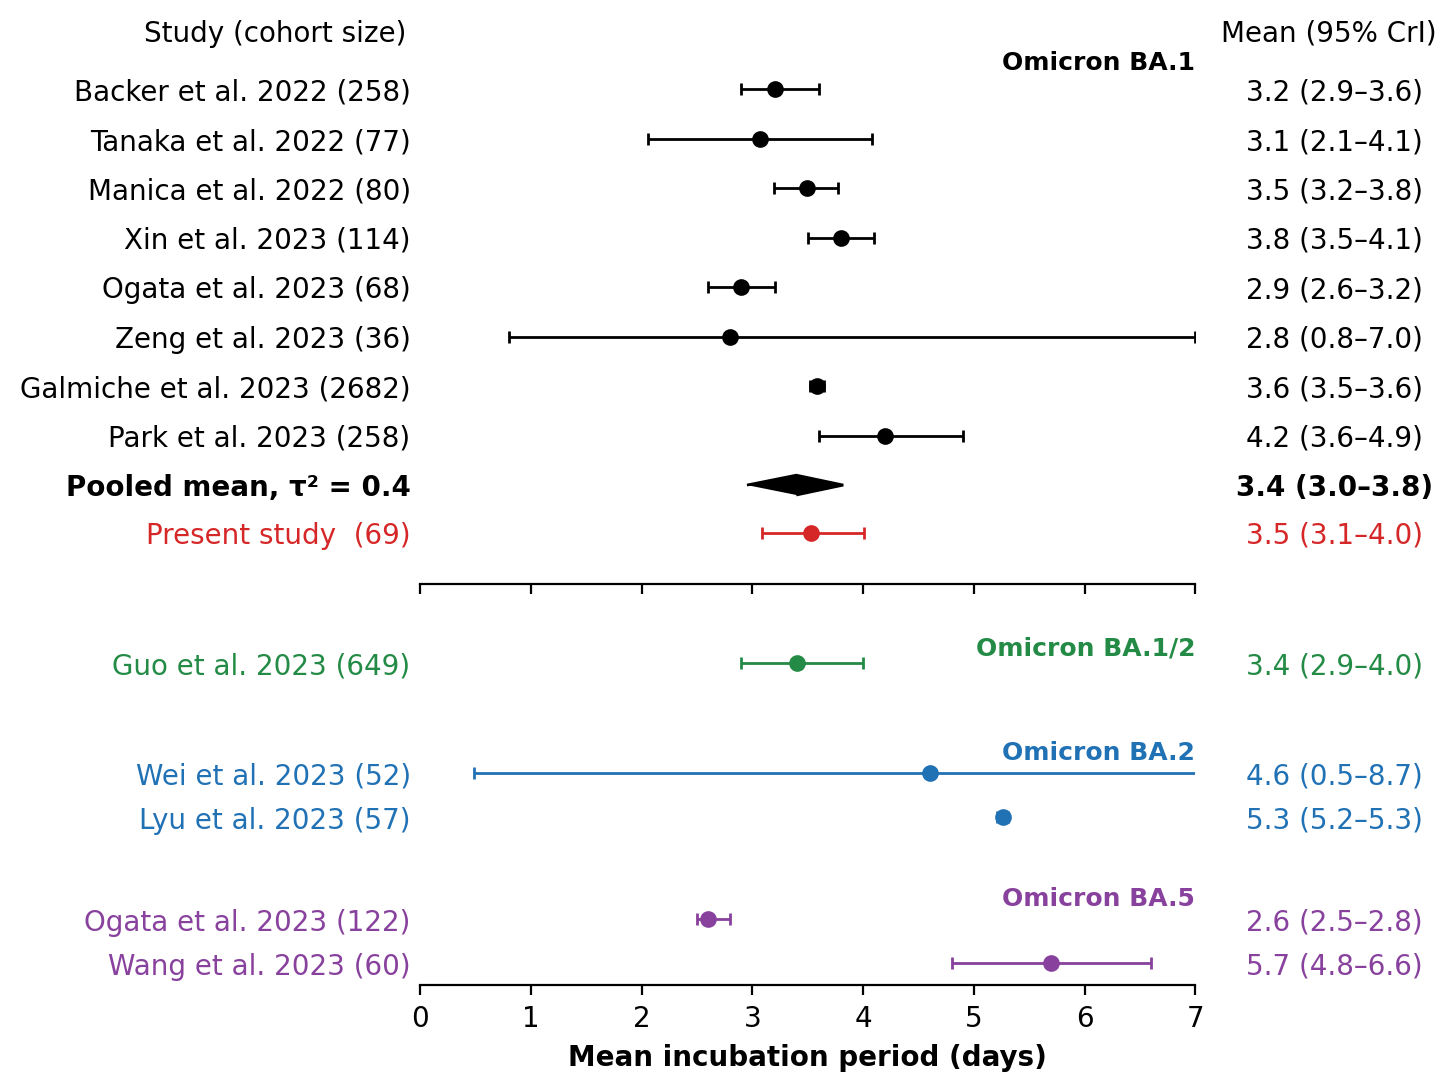

In [138]:
fig, (ax1, ax7, ax3, ax5) = plt.subplots(4, 1, sharex=True, gridspec_kw={'height_ratios': [3, .22, .43, .43], 'hspace': .4})

clr_BA1 = 'k'
clr_BA2 = '#2171b5'
clr_BA12 = '#238b45'
clr_BA5 = '#88419d'

fig.set_size_inches(5, 6); 

df_ = df_inc_review_analyzed.loc[lambda d: d.Subvariant=='BA.1'].copy()

df_['Source'] = df_['Study']
df_['Source'] = [x + ' (' + str(z) + ')' for x,z in zip(df_['Study'], df_['CohortSize'])]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax1.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Mean_lower']), list(df_['Mean_upper'] - df_['Mean'])], color='black', capsize=2,
             linestyle='None', linewidth=1, markersize=0)
ax1.plot(list(df_['Mean']), df_['Source_y'], color='black', mfc='k', 
         linestyle='None', linewidth=1, marker="o", ms=5)

# Pooled mean
mean_meta = df_meta_incper_BA1_summary.loc[lambda d: d['var']=='mu', 'mean'].values[0]
lower_meta = df_meta_incper_BA1_summary.loc[lambda d: d['var']=='mu', 'lower'].values[0]
upper_meta = df_meta_incper_BA1_summary.loc[lambda d: d['var']=='mu', 'upper'].values[0]
τsqr_meta = df_meta_incper_BA1_summary.loc[lambda d: d['var']=='tau_squared', 'mean'].values[0]
y_ = 0.0
h_ = 0.2/df_.shape[0]
from matplotlib.patches import Polygon
pts = np.array([[lower_meta, y_], [mean_meta,y_+h_], [upper_meta, y_], [mean_meta, y_-h_], [lower_meta, y_]])
p = Polygon(pts, closed=False, color='k')
ax1.add_patch(p)

## current study
df__ = df_current_study.copy()
df__['Source'] = [x + '  (' + str(z) + ')' for x,z in zip(df__['Source'], df__['CohortSize'])]

y__ = -0.12
clr_ = 'C3'

ax1.errorbar(x=list(df__['mu']), y=y__, 
             xerr=[list(df__['mu'] - df__['mu_lower']), list(df__['mu_upper'] - df__['mu'])], color=clr_, capsize=2,
             linestyle='None', linewidth=1, markersize=0)
ax1.plot(list(df__['mu']), y__, color=clr_, linestyle='None', linewidth=1, marker="o", ms=5)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='y', length=0)
# ax1.spines['bottom'].set_linestyle((0,(4,4)))
# ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(left = 0, right=7)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_ylim(-2./df_.shape[0], 1.07)
ax1.set_yticks(np.r_[df_['Source_y'], y_, [y__]])
ax1.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}'], df__['Source']] )

ax2 = ax1.secondary_yaxis("right")
ax2.set_yticks(ax1.get_yticks())
ax2.spines['right'].set_visible(False)
ax2.tick_params(length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Mean_lower'], df_['Mean_upper'])]
df_current_study['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_current_study['mu'], df_current_study['mu_lower'], df_current_study['mu_upper'])]
ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})'], df_current_study['label']], ha='center', fontsize=10)
ax2.yaxis.set_tick_params(pad=50)

[label.set_fontweight('bold') if 'Pool' in label.get_text() else None for label in ax1.get_yticklabels()]
[label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]

[label.set_color(clr_) if 'Present' in label.get_text() else None for label in ax1.get_yticklabels()]
[label2.set_color(clr_) if 'Present' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]

ax1.text(-2.5, 1.12, 'Study (cohort size)', horizontalalignment='left', fontsize=10)
ax1.text(9.18, 1.12, 'Mean (95% CrI)', horizontalalignment='right', fontsize=10)

### BA.1/2 ###
df_ = df_inc_review_analyzed.loc[lambda d: d.Subvariant=='BA.1/2'].copy()

df_['Source'] = df_['Study']
df_['Source'] = [x + ' (' + str(z) + ')' for x,z in zip(df_['Study'], df_['CohortSize'])]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax7.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Mean_lower']), list(df_['Mean_upper'] - df_['Mean'])], color=clr_BA12, capsize=2,
             linestyle='None', linewidth=1, markersize=0)
ax7.plot(list(df_['Mean']), df_['Source_y'], color=clr_BA12, 
         linestyle='None', linewidth=1, marker="o", ms=5)

ax7.spines['top'].set_visible(False)
ax7.spines['left'].set_visible(False)
# ax7.spines['bottom'].set_linestyle((0,(4,4)))
ax7.spines['bottom'].set_visible(False)
ax7.tick_params(length=0)
ax7.spines['right'].set_visible(False)
ax7.set_xlim(left = 0, right=7)
ax7.get_xaxis().tick_bottom()
ax7.get_yaxis().tick_left()

ax7.set_yticks(df_['Source_y'])
ax7.set_yticklabels(df_['Source'])
ax7.set_ylim(0.25, 1.2)

ax8 = ax7.secondary_yaxis("right")
ax8.set_yticks(ax7.get_yticks())
ax8.spines['right'].set_visible(False)
ax8.tick_params(length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Mean_lower'], df_['Mean_upper'])]
ax8.set_yticklabels(df_['label'].values, ha='center', fontsize=10)
ax8.yaxis.set_tick_params(pad=50)

[label.set_color(clr_BA12) for label in ax7.get_yticklabels()]
[label.set_color(clr_BA12) for label in ax8.get_yticklabels()]

### BA.2 ###
df_ = df_inc_review_analyzed.loc[lambda d: d.Subvariant=='BA.2'].copy()

df_['Source'] = df_['Study']
df_['Source'] = [x + ' (' + str(z) + ')' for x,z in zip(df_['Study'], df_['CohortSize'])]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax3.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Mean_lower']), list(df_['Mean_upper'] - df_['Mean'])], color=clr_BA2, capsize=2,
             linestyle='None', linewidth=1, markersize=0)
ax3.plot(list(df_['Mean']), df_['Source_y'], color=clr_BA2, 
         linestyle='None', linewidth=1, marker="o", ms=5)

ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
# ax3.spines['bottom'].set_linestyle((0,(4,4)))
ax3.spines['bottom'].set_visible(False)
ax3.tick_params(length=0)
ax3.spines['right'].set_visible(False)
ax3.set_xlim(left = 0, right=7)
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()

# ax3.set_xlabel("Mean incubation period (days)")
ax3.set_yticks(df_['Source_y'])
ax3.set_yticklabels(df_['Source'])
ax3.set_ylim(0.25, 1.1)

ax4 = ax3.secondary_yaxis("right")
ax4.set_yticks(ax3.get_yticks())
ax4.spines['right'].set_visible(False)
ax4.tick_params(length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Mean_lower'], df_['Mean_upper'])]
ax4.set_yticklabels(df_['label'].values, ha='center', fontsize=10)
ax4.yaxis.set_tick_params(pad=50)

[label.set_color(clr_BA2) for label in ax3.get_yticklabels()]
[label.set_color(clr_BA2) for label in ax4.get_yticklabels()]

### BA.5 ###
df_ = df_inc_review_analyzed.loc[lambda d: d.Subvariant=='BA.5'].copy()
df_['Source'] = df_['Study']
df_['Source'] = [x + ' (' + str(z) + ')' for x,z in zip(df_['Study'], df_['CohortSize'])]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax5.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Mean_lower']), list(df_['Mean_upper'] - df_['Mean'])], color=clr_BA5, capsize=2,
             linestyle='None', linewidth=1, markersize=0)
ax5.plot(list(df_['Mean']), df_['Source_y'], color=clr_BA5,
         linestyle='None', linewidth=1, marker="o", ms=5)

ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.tick_params(axis='y', length=0)
ax5.spines['right'].set_visible(False)
ax5.set_xlim(left = 0, right=7)
ax5.get_xaxis().tick_bottom()
ax5.get_yaxis().tick_left()

ax5.set_xlabel("Mean incubation period (days)")
ax5.set_yticks(df_['Source_y'])
ax5.set_yticklabels(df_['Source'])
ax5.set_ylim(0.25, 1.1)

ax6 = ax5.secondary_yaxis("right")
ax6.set_yticks(ax5.get_yticks())
ax6.spines['right'].set_visible(False)
ax6.tick_params(length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Mean_lower'], df_['Mean_upper'])]
ax6.set_yticklabels(df_['label'].values, ha='center', fontsize=10)
ax6.yaxis.set_tick_params(pad=50)

[label.set_color(clr_BA5) for label in ax5.get_yticklabels()]
[label.set_color(clr_BA5) for label in ax6.get_yticklabels()]

ax1.text(7., 1.05, 'Omicron BA.1', horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_BA1)
ax3.text(7., 1.15, 'Omicron BA.2', horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_BA2)
ax7.text(7., 1.2, 'Omicron BA.1/2', horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_BA12)
ax5.text(7., 1.15, 'Omicron BA.5', horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_BA5)

if save_figures:
    plt.savefig("../figures/draft/fig-incper_Omicron_meta.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [131]:
df_inc_review_Du = pd.read_excel('../data/review_Du.xlsx').reset_index(drop=True)
df_inc_review_Du

Source  Lower  Upper  Mean
0     Pre-Alpha    1.8   11.9   6.3
1         Delta    3.9    5.6   4.8
2  Omicron BA.1    2.3    4.9   3.6

In [132]:
df_inc_review_Wu = pd.read_excel('../data/review_Wu.xlsx').reset_index(drop=True)
df_inc_review_Wu

Source  Lower  Upper  Mean
0     Pre-Alpha   6.31   6.99  6.65
1         Alpha   4.94   5.06  5.00
2         Delta   3.76   5.05  4.41
3  Omicron BA.1   2.88   3.96  3.42

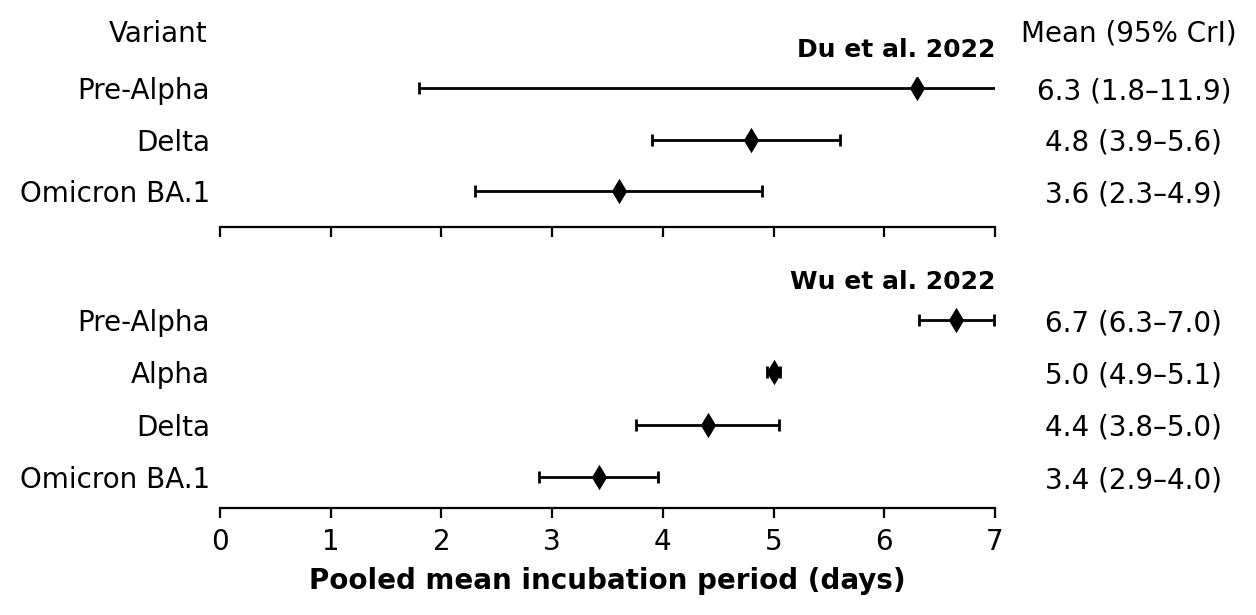

In [139]:
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 1.4], 'hspace': .4})
fig.set_size_inches(5, 2.8); 

clr_Du = 'k'
clr_Wu = 'k'

## Du et al. ##
df_ = df_inc_review_Du.copy()[::-1]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax1.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Lower']), list(df_['Upper'] - df_['Mean'])], capsize=2,
             linestyle='None', linewidth=1, markersize=0, color=clr_Du)
ax1.plot(list(df_['Mean']), df_['Source_y'], color=clr_Du, linestyle='None', linewidth=1, marker="d", ms=5)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='y', length=0)
# ax1.spines['bottom'].set_linestyle((0,(4,4)))
# ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(left = 0, right=7)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_ylim(.1, 1.07)
ax1.set_yticks(df_['Source_y'])
ax1.set_yticklabels(df_['Source'])

ax2 = ax1.secondary_yaxis("right")
ax2.set_yticks(ax1.get_yticks())
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y',length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Lower'], df_['Upper'])]
ax2.set_yticklabels(df_['label'], ha='center', fontsize=10)
ax2.yaxis.set_tick_params(pad=50)

ax1.text(-1., 1.3, 'Variant', horizontalalignment='left', fontsize=10)
ax1.text(9.18, 1.3, 'Mean (95% CrI)', horizontalalignment='right', fontsize=10)

## Wu et al. ##
df_ = df_inc_review_Wu.copy()[::-1]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax3.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Lower']), list(df_['Upper'] - df_['Mean'])], color=clr_Wu, capsize=2,
             linestyle='None', linewidth=1, markersize=0)
ax3.plot(list(df_['Mean']), df_['Source_y'], color=clr_Wu, linestyle='None', linewidth=1, marker="d", ms=5)

ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.tick_params(axis='y',length=0)
ax3.spines['right'].set_visible(False)
ax3.set_xlim(left = 0, right=7)
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()

ax3.set_xlabel("Pooled mean incubation period (days)")
ax3.set_yticks(df_['Source_y'])
ax3.set_yticklabels(df_['Source'])
ax3.set_ylim(0.1, 1.1)

ax4 = ax3.secondary_yaxis("right")
ax4.set_yticks(ax3.get_yticks())
ax4.spines['right'].set_visible(False)
ax4.tick_params(axis='y',length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Lower'], df_['Upper'])]
ax4.set_yticklabels(df_['label'].values, ha='center', fontsize=10)
ax4.yaxis.set_tick_params(pad=50)

[label.set_color(clr_Wu) for label in ax3.get_yticklabels()]
[label.set_color(clr_Wu) for label in ax4.get_yticklabels()]

ax1.text(7., 1.2, 'Du et al. 2022', horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_Du)
ax3.text(7., 1.15, 'Wu et al. 2022', horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_Wu)

if save_figures:
    plt.savefig("../figures/draft/fig-incper_Reviews.pdf", format="pdf", bbox_inches="tight")

plt.show()